In [2]:
# For each different vector, get the associated class vector
def encode_cell_function(cell_function, cell_functions_list):
    return(cell_functions_list.index(cell_function))

# Compute one-hot encoding
# Use alphabetical order of CAR domains: 41BB, CD28, CD40, CTLA4, IL15RA
# 0 everywhere is TCR-

def encode_domain(domain_name, order):
    CAR_variant = domain_name.split("_")
    domains = ["h4-1BB", "hCD28", "hCD40", "hCTLA-4", "hIL15RA"] # The h is an artefact (of scanpy?)
    l = len(CAR_variant)
    if order == False:
        encoding = [0,0,0,0,0]
        if l>1: # Otherwise it's a TCR- cell
            index_1 = domains.index(CAR_variant[0])
            encoding[index_1] = 1
            if "NA" not in CAR_variant[1]:
                index_2 = domains.index(CAR_variant[1])
                encoding[index_2] = 1

    else:
        encoding = [0,0,0,0,0,0,0,0,0,0]
        if l>1:
            index_1 = domains.index(CAR_variant[0])
            encoding[index_1] = 1
            if "NA" not in CAR_variant[1]:
                index_2 = domains.index(CAR_variant[1])
                encoding[index_2 + 5] = 1
    return(encoding)

# Classification

In [3]:
# The order in cell function is the one we'll use for the multi-label encoding
# We'll encode the cell function on an 8-bits vector
# We'll use the same training and test set as before but we have to modify the values
expression_sc = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes.csv")
cell_functions_list= list(np.unique(expression_sc["cell_type"]))

In [4]:

expression_sc = expression_sc[["CAR_Variant", "cell_type", "Type"]]
expression_sc["encoding_5"] = expression_sc["CAR_Variant"].apply(encode_domain, args = (False,))
expression_sc["encoding_10"] = expression_sc["CAR_Variant"].apply(encode_domain, args = (True,))



print(cell_functions_list)
expression_sc["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function, args=(cell_functions_list, ))


# Separate the CD4 cells from the CD8 cells

expression_sc_CD4 = expression_sc[expression_sc["Type"]  == 'CD4']
expression_sc_CD8 = expression_sc[expression_sc["Type"]  == 'CD8']

CD4_functions = list(np.unique(expression_sc_CD4["cell_type"]))
CD8_functions = list(np.unique(expression_sc_CD8["cell_type"]))



# Since I have the single cell data, which is big I'm going to use a random train-test split
# Instead of manually curating the sets as before
[training_sc_CD4, validation_sc_CD4] = train_test_split(expression_sc_CD4, test_size= 0.2, random_state = 1)
[training_sc_CD8, validation_sc_CD8] = train_test_split(expression_sc_CD8, test_size= 0.2, random_state = 1)


# Check that we have all the domains in the training data
n_tot = len(np.unique(expression_sc["CAR_Variant"]))
n_CD4 = len(np.unique(training_sc_CD4["CAR_Variant"]))
n_CD8 = len(np.unique(training_sc_CD8["CAR_Variant"]))
print(f"Total number of CAR variants: {n_tot}")
print(f"number of different CAR variants in the CD4 training set: {n_CD4}")
print(f"number of different CAR variants in the CD8 training set: {n_CD8}")      


training_inputs_5_CD4 =  np.asarray(list(training_sc_CD4["encoding_5"]))
training_inputs_10_CD4 =  np.asarray(list(training_sc_CD4["encoding_10"]))
training_values_CD4 = np.asarray(list(training_sc_CD4["function_encoded"]))

validation_inputs_5_CD4 =  np.asarray(list(validation_sc_CD4["encoding_5"]))
validation_inputs_10_CD4 =  np.asarray(list(validation_sc_CD4["encoding_10"]))
validation_values_CD4 = np.asarray(list(validation_sc_CD4["function_encoded"]))

training_inputs_5_CD8 =  np.asarray(list(training_sc_CD8["encoding_5"]))
training_inputs_10_CD8 =  np.asarray(list(training_sc_CD8["encoding_10"]))
training_values_CD8 = np.asarray(list(training_sc_CD8["function_encoded"]))

validation_inputs_5_CD8 =  np.asarray(list(validation_sc_CD8["encoding_5"]))
validation_inputs_10_CD8 =  np.asarray(list(validation_sc_CD8["encoding_10"]))
validation_values_CD8 = np.asarray(list(validation_sc_CD8["function_encoded"]))

cell_functions_list[3] = "CD4 Activated"
cell_functions_list[4] = "CD8 Cytotoxic/Memory"

['CD4 HLAhigh', 'CD4 Memory', 'CD4 Th2/Activated', 'CD4 activated', 'CD8 Cytox/Memory', 'CD8 Effector A', 'CD8 Effector HLAhigh', 'NK T cell']
Total number of CAR variants: 31
number of different CAR variants in the CD4 training set: 31
number of different CAR variants in the CD8 training set: 30


# Take a look at the data

**The CD8 set is missing a hCTLA4-hCTLA4 datapoint because there is only one such datapoint in the while CD8 dataset (see figure)**
Namely, is a classification possible, ie: is there a simgle function associated to each domain pair or not?



<Figure size 432x288 with 0 Axes>

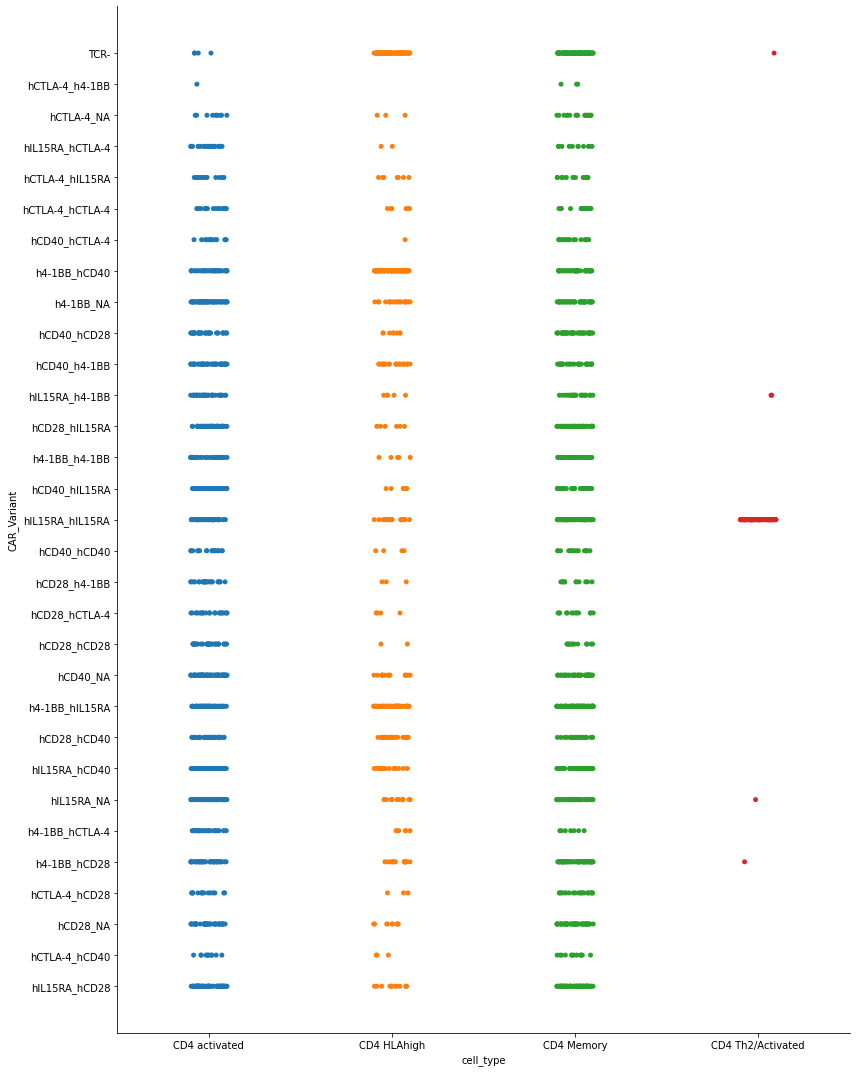

In [5]:
# Figure out which domains map to which class
# CD 4 cells
plt.figure()
sns.catplot(data = expression_sc_CD4, y = "CAR_Variant", x = "cell_type", height=15, aspect = 0.8)

<Figure size 432x288 with 0 Axes>

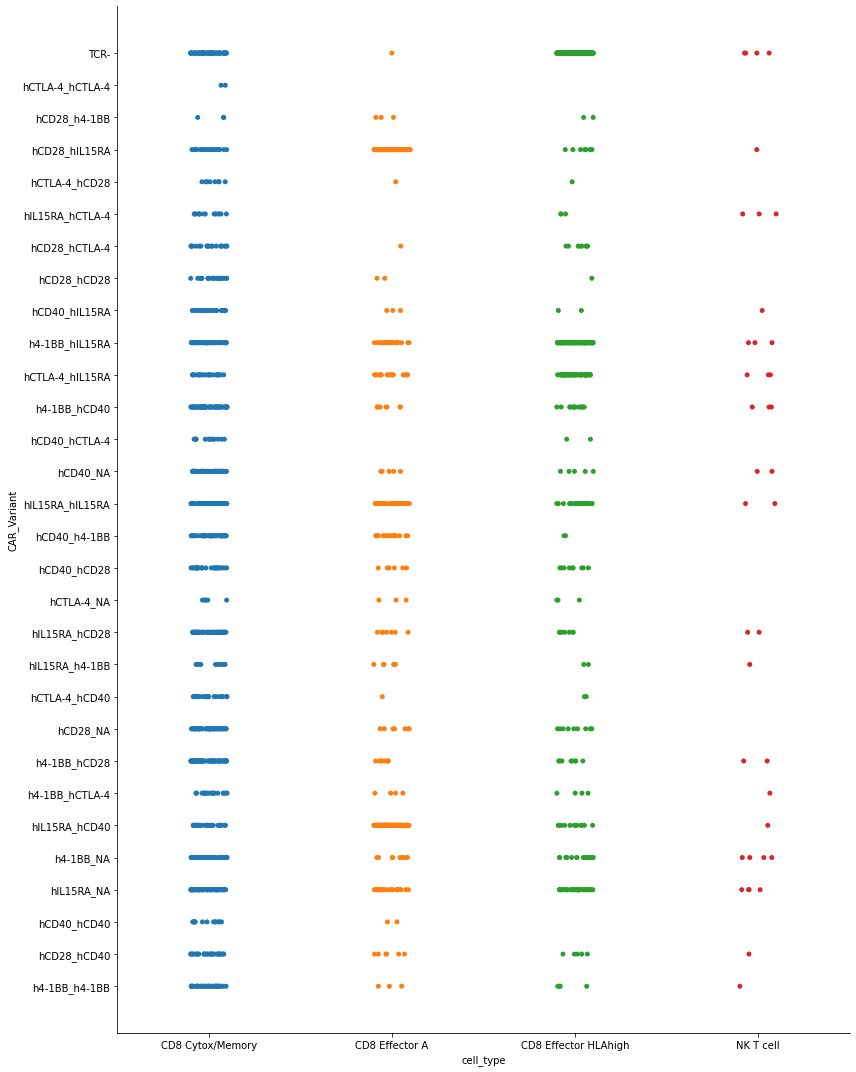

In [6]:
# Figure out which domains map to which class
# CD 8 cells
plt.figure()
sns.catplot(data = expression_sc_CD8, y = "CAR_Variant", x = "cell_type", height=15, aspect = 0.8)

In [7]:
def sum_functions(df):
    """
        See numbers of cells per CAR Variant and cell type
    """
    
    L = len(df.index)
    final_df = pd.DataFrame(data = np.zeros((L, 9)),columns=["CAR_Variant", "CD4 activated",
                                     "CD4 HLAhigh", "CD4 Memory", "CD4 Th2/Activated",
                                    "CD8 Cytox/Memory", "CD8 Effector A", "CD8 Effector HLAhigh",
                                     "NK T cell"])
    final_df["CAR_Variant"] = df["CAR_Variant"]
    
    for row in range(L):
        function = df.loc[row, "cell_type"]
        final_df.loc[row, function] = 1
    
    return(final_df.groupby("CAR_Variant").sum())

In [8]:
sum_functions(expression_sc)

,CD4 activated,CD4 HLAhigh,CD4 Memory,CD4 Th2/Activated,CD8 Cytox/Memory,CD8 Effector A,CD8 Effector HLAhigh,NK T cell
CAR_Variant,,,,,,,,
TCR-,4.0,99.0,96.0,1.0,74.0,1.0,221.0,4.0
h4-1BB_NA,59.0,19.0,45.0,0.0,84.0,9.0,15.0,4.0
h4-1BB_h4-1BB,40.0,5.0,39.0,0.0,37.0,3.0,4.0,1.0
h4-1BB_hCD28,39.0,14.0,57.0,1.0,68.0,8.0,8.0,2.0
h4-1BB_hCD40,36.0,88.0,45.0,0.0,62.0,7.0,13.0,3.0
h4-1BB_hCTLA-4,25.0,6.0,7.0,0.0,19.0,4.0,4.0,1.0
h4-1BB_hIL15RA,54.0,61.0,80.0,0.0,51.0,24.0,139.0,3.0
hCD28_NA,42.0,9.0,48.0,0.0,49.0,7.0,9.0,0.0
hCD28_h4-1BB,24.0,3.0,11.0,0.0,3.0,3.0,2.0,0.0


In [9]:
sum_functions(expression_sc).sum()

CD4 activated           1037.0
CD4 HLAhigh              494.0
CD4 Memory              1059.0
CD4 Th2/Activated        103.0
CD8 Cytox/Memory        1036.0
CD8 Effector A           368.0
CD8 Effector HLAhigh     615.0
NK T cell                 39.0
dtype: float64

This plot here is my main problem with the classification problem: most domain pairs map to a a lot of possible functions! Even separating CD4 and CD8 there's still quite a few pairs which map to several domains. I would say this is slightly more pronounced in the CD4 set where most fomains can lead to both CD4 Activated and CD4 Memory. For CD8, most domains seem to lead to CD8 Cytotoxix/Memory, while those that lead to a continuous bar at Effector all seem to contain the IL15RA domain.

We also notice there is a **big class imbalance**: the classes CD4/TH2 activated (for CD4) and NK T cell (for CD8) are highly underrepresenetd in the dataset.




# Sanity check: Predict celltype from marker genes expression

In [10]:
marker_genes = pickle.load(open("../../CAR_data/marker_genes", "rb"))
marker_genes_expression = pd.read_csv("../../CAR_data/marker_genes_log_sc_expr_with_celltypes.csv", index_col = 0)

In [11]:
cell_functions_list= list(np.unique(expression_sc["cell_type"]))
marker_genes_expression["function_encoded"] =  marker_genes_expression["cell_type"].apply(encode_cell_function, args=(cell_functions_list, ))
marker_genes_expression

,BATF3,CCL3,CCL4,CCL5,CCR4,CCR5,CCR7,CD27,CD4,CD40LG,...,HLA-DMA,HLA-DOA,HLA-DRB5,HLA-DQA1,HLA-DRB1,HLA-DQB1,CAR_Variant,Type,cell_type,function_encoded
AAACGAAAGGTAAGGA-1-1,0.217948,0.000000,1.588491,0.217948,0.000000,0.000000,1.483719,0.548449,0.000000,0.000000,...,0.217948,0.000000,0.217948,0.000000,0.217948,0.000000,h4-1BB_h4-1BB,CD8,CD8 Cytox/Memory,4
AAACGAAGTACGCGTC-1-1,0.000000,0.000000,2.517899,1.902295,0.000000,0.000000,1.348236,1.902295,0.000000,0.000000,...,0.000000,0.000000,1.348236,0.000000,0.000000,0.000000,h4-1BB_hIL15RA,CD8,CD8 Effector A,5
AAACGCTGTGTTCCAA-1-1,0.423257,0.000000,0.423257,0.000000,0.000000,0.000000,2.060518,1.916362,0.423257,0.948091,...,0.000000,0.000000,0.000000,0.423257,0.000000,0.423257,hIL15RA_hCD28,CD4,CD4 activated,3
AAAGAACGTTACCTTT-1-1,0.000000,0.000000,0.000000,3.857315,0.000000,0.000000,0.000000,1.388534,0.000000,0.000000,...,0.000000,0.471124,1.031539,0.471124,1.528393,1.651070,hIL15RA_hCTLA-4,CD8,CD8 Effector HLAhigh,6
AAAGGATAGTCTTCCC-1-1,0.540534,0.164862,0.164862,0.164862,0.430283,0.164862,1.026868,0.730146,0.306353,1.089080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,hCTLA-4_hCD40,CD4,CD4 activated,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTTCCTAGCCT-1-TCR,0.000000,0.000000,0.000000,3.302313,0.000000,0.401374,0.401374,1.377066,0.000000,0.000000,...,0.908915,0.000000,1.090413,1.494505,1.694676,1.781500,TCR-,CD8,CD8 Effector HLAhigh,6
TTGTTTGTCTATGCCC-1-TCR,1.069735,0.000000,0.000000,4.161724,0.000000,0.000000,0.000000,1.574684,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.574684,TCR-,CD8,CD8 Effector HLAhigh,6
TTTACCAGTCTGTGAT-1-TCR,0.000000,0.000000,0.000000,0.811208,0.000000,0.000000,2.277716,0.000000,0.000000,0.811208,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TCR-,CD4,CD4 Memory,1
TTTACGTTCACTTTGT-1-TCR,0.782006,0.000000,0.000000,2.405119,0.000000,0.465573,1.123384,0.000000,0.000000,0.000000,...,0.909192,0.000000,1.123384,0.782006,1.798383,1.516787,TCR-,CD8,CD8 Effector HLAhigh,6


In [12]:
# Separate in a train and test set
[training_set, validation_set] = train_test_split(marker_genes_expression, test_size= 0.2, random_state = 1)

# Create a random forest
rf = sklearn.ensemble.RandomForestClassifier(random_state=2)
rf.fit(X = training_set[marker_genes], y = training_set["function_encoded"])
pred = rf.predict(validation_set[marker_genes])

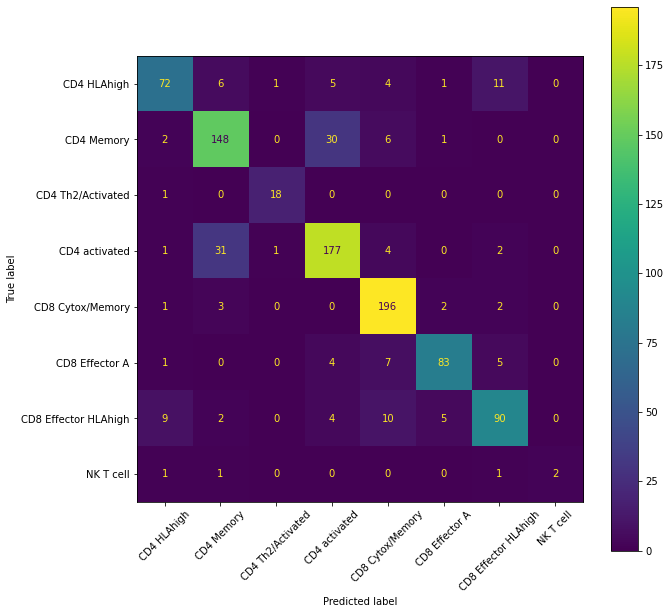

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(validation_set["function_encoded"], pred, labels=[0,1,2,3, 4, 5, 6, 7])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cell_functions_list)
disp.plot(ax = ax)
disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), rotation = 45)

plt.show()



# Classification from domain name (including order)

In [14]:
# Recover the pretty names I want for the report
cell_functions= list(np.unique(expression_sc["cell_type"]))
cell_functions[3] = "CD4 Activated"
cell_functions[4] = "CD8 Cytotoxic/Memory"
print(cell_functions)

['CD4 HLAhigh', 'CD4 Memory', 'CD4 Th2/Activated', 'CD4 Activated', 'CD8 Cytotoxic/Memory', 'CD8 Effector A', 'CD8 Effector HLAhigh', 'NK T cell']


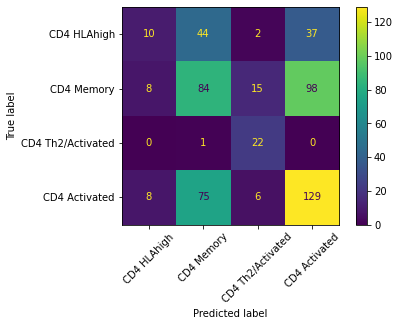

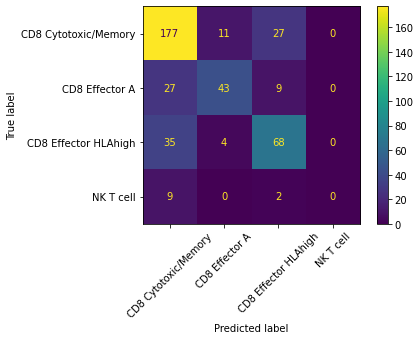

Classification report on the validation set CD8
                   precision    recall  f1-score   support

      CD4 HLAhigh       0.38      0.11      0.17        93
       CD4 Memory       0.41      0.41      0.41       205
CD4 Th2/Activated       0.49      0.96      0.65        23
    CD4 activated       0.49      0.59      0.54       218

         accuracy                           0.45       539
        macro avg       0.44      0.52      0.44       539
     weighted avg       0.44      0.45      0.43       539

Classification report on the validation set CD8
                      precision    recall  f1-score   support

    CD8 Cytox/Memory       0.71      0.82      0.76       215
      CD8 Effector A       0.74      0.54      0.63        79
CD8 Effector HLAhigh       0.64      0.64      0.64       107
           NK T cell       0.00      0.00      0.00        11

            accuracy                           0.70       412
           macro avg       0.52      0.50      0.51    

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [15]:
rf_CD4 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, random_state=2)
rf_CD8 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, random_state=2)

rf_CD4.fit(X = training_inputs_10_CD4, y = training_values_CD4)
pred_CD4 = rf_CD4.predict(X = validation_inputs_10_CD4)

rf_CD8.fit(X = training_inputs_10_CD8, y = training_values_CD8)
pred_CD8 = rf_CD8.predict(X = validation_inputs_10_CD8)

# Check what I am predicting with a heatmap of the true counts vs the predicted counts for each class

bincount_pred_CD4 = np.bincount(pred_CD4)
bincount_pred_CD8 = np.bincount(pred_CD8)
bincount_true_CD4 = np.bincount(validation_values_CD4)
bincount_true_CD8 = np.bincount(validation_values_CD8)
if len (bincount_pred_CD8)<8:
    bincount_pred_CD8 = np.asarray(list(bincount_pred_CD8) + [0]) # There may be no NK T cells in the validation set

true_counts_CD4 = pd.DataFrame({"CD4 HLAhigh": bincount_true_CD4[0],
                                "CD4 Memory": bincount_true_CD4[1],
                                "CD4 TH2/Activated": bincount_true_CD4[2],
                                "CD4 activated": bincount_true_CD4[3]
                               
                               }, index = [1])
true_counts_CD8 = pd.DataFrame({"CD8 Cytox/Memory": bincount_true_CD8[4],
                                "CD8 Effector A": bincount_true_CD8[5],
                                "CD8 Effector HLAhigh": bincount_true_CD8[6],
                                "NK T cell": bincount_true_CD8[7]                               
                               }, index = [1])


pred_counts_CD4 = pd.DataFrame({"CD4 HLAhigh": bincount_pred_CD4[0],
                                "CD4 Memory": bincount_pred_CD4[1],
                                "CD4 TH2/Activated": bincount_pred_CD4[2],
                                "CD4 Activated": bincount_pred_CD4[3]
                               
                               }, index = [1])

pred_counts_CD8 = pd.DataFrame({"CD8 Cytotoxic/Memory": bincount_pred_CD8[4],
                                "CD8 Effector A": bincount_pred_CD8[5],
                                "CD8 Effector HLAhigh": bincount_pred_CD8[6],
                                "NK T cell": bincount_pred_CD8[7]                               
                               }, index = [1])

cm_CD4 = sklearn.metrics.confusion_matrix(validation_values_CD4, pred_CD4, labels=[0,1,2,3])
disp_CD4 = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_CD4,
                              display_labels=cell_functions[0:4])
disp_CD4.plot()
disp_CD4.ax_.set_xticklabels(disp_CD4.ax_.get_xmajorticklabels(), rotation=45)
plt.show()


cm_CD8 = sklearn.metrics.confusion_matrix(validation_values_CD8, pred_CD8, labels=[4,5,6,7])
disp_CD8 = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_CD8,
                              display_labels=cell_functions[4:8])

disp_CD8.plot()
disp_CD8.ax_.set_xticklabels(disp_CD8.ax_.get_xmajorticklabels(), rotation = 45)
plt.show()

print("Classification report on the validation set CD8") 
print(classification_report(validation_values_CD4, pred_CD4, target_names=CD4_functions,
                            zero_division="warn" ))

print("Classification report on the validation set CD8") 
print(classification_report(validation_values_CD8, pred_CD8, target_names=CD8_functions,
                            zero_division="warn" ))

CD4_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_true = validation_values_CD4, y_pred = pred_CD4)
CD8_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_true = validation_values_CD8, y_pred = pred_CD8)

print(f"Balanced accuracy: CD4: {CD4_balanced_accuracy}, CD8:{CD8_balanced_accuracy}")

In [16]:
font = {'family' : 'normal',
        'weight': "normal",
        'size'   : 14}

plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


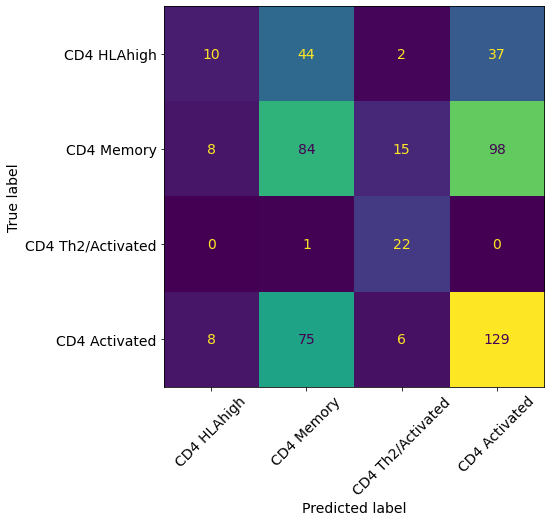

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
disp_CD4.plot(ax = ax, colorbar=False)
disp_CD4.ax_.set_xticklabels(disp_CD4.ax_.get_xmajorticklabels(), rotation=45)
plt.show()

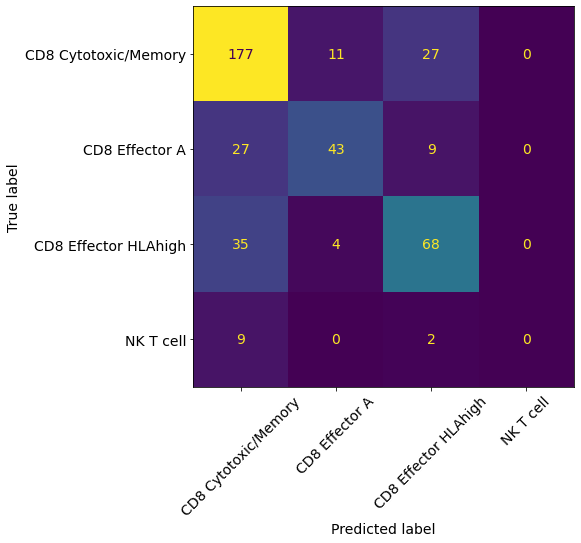

In [18]:
fig, ax = plt.subplots(figsize=(7,7))
disp_CD8.plot(ax = ax, colorbar=False)
disp_CD8.ax_.set_xticklabels(disp_CD8.ax_.get_xmajorticklabels(),rotation=45)
plt.show()



# For completeness: run a GridSearch on the classification

In [19]:
rf_params = {"random_state":[2], "n_estimators": [100,200,500],
            "criterion": ["gini", "log_loss"],
             "max_depth": [None, 50, 100, 500],
            "class_weight": [None, "balanced" ], 
            "max_leaf_nodes": [None, 50, 100]}

clf_4 = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=2), rf_params, verbose = 4,
                     scoring = ["balanced_accuracy", "accuracy"], refit = "accuracy")
clf_4.fit(training_inputs_10_CD4, training_values_CD4)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.2s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.463) balanced_accuracy: (tes

[CV 4/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.9s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   1.0s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=g

[CV 3/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.9s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.9s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.9s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=gini

[CV 1/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.9s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.9s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   1.0s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.9s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.9s
[CV 1/5] END class_weight=None, criterion=gin

[CV 4/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.3s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.3s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.9s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.9s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.9s
[CV 4/5] END class_weight=None, criterion=gin

[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.4s
[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.542) total time=   0.4s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.4s
[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.4s
[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.4s
[CV 1/5] END class_w

[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.2s
[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.2s
[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.4s
[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.542) total time=   0.4s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.4s
[CV 4/5] END class_weight=None

[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.2s
[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.2s
[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.4s
[CV 2/5] END class_weight

[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.463) balanced_accuracy: (test=0.556) total time=   0.9s
[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.478) balanced_accuracy: (test=0.546) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.452) balanced_accuracy: (test=0.558) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.541) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.483) balanced_accuracy: (test=0.554) total time=   0.2s
[CV 5/5] END class_weight=

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.610) total time=   0.9s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   1.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.574) total time=   0.9s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.449) balanced_accuracy: (test=0.571) total time=   0.9s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.573) total time=   0.2s
[CV 2/5] END class_weigh

[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.451) balanced_accuracy: (test=0.572) total time=   0.4s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.573) total time=   0.9s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.610) total time=   1.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.9s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.574) total time=   0.9s
[CV 5/5] END class_weight=balanced,

[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.4s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.582) total time=   0.4s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.451) balanced_accuracy: (test=0.572) total time=   0.3s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.573) total time=   0.9s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.610) total time=   0.9s
[CV 3/5] END class_weight=bala

[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.457) balanced_accuracy: (test=0.577) total time=   0.4s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.610) total time=   0.4s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.4s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.462) balanced_accuracy: (test=0.582) total time=   0.4s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.451) balanced_accuracy: (test=0.572) total time=   0.4s
[CV 1/5] END class_weight=bala

[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.587) total time=   0.2s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.453) balanced_accuracy: (test=0.574) total time=   0.2s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.457) balanced_accuracy: (test=0.577) total time=   0.4s
[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.610) total time=   0.4s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.4s
[CV 4

[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.476) balanced_accuracy: (test=0.617) total time=   0.2s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.2s
[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.587) total time=   0.2s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.453) balanced_accuracy: (test=0.574) total time=   0.2s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.457) balanced_accuracy: (test=0.577) total time=   0.4s
[CV 2/5] END cl

[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.574) total time=   0.9s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.449) balanced_accuracy: (test=0.571) total time=   0.9s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.573) total time=   0.2s
[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.476) balanced_accuracy: (test=0.617) total time=   0.2s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.2s
[CV 4/

[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.573) total time=   0.8s
[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.610) total time=   0.9s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.469) balanced_accuracy: (test=0.603) total time=   0.9s
[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.450) balanced_accuracy: (test=0.574) total time=   0.9s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.449) balanced_accuracy: (test=0.571) total time=   1.0s


GridSearchCV(estimator=RandomForestClassifier(random_state=2),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'log_loss'],
                         'max_depth': [None, 50, 100, 500],
                         'max_leaf_nodes': [None, 50, 100],
                         'n_estimators': [100, 200, 500], 'random_state': [2]},
             refit='accuracy', scoring=['balanced_accuracy', 'accuracy'],
             verbose=4)

In [20]:
clf_8 = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=2), rf_params, verbose = 4, scoring = ["balanced_accuracy", "accuracy"], refit = "accuracy")
clf_8.fit(training_inputs_10_CD8, training_values_CD8)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.685) balanced_accuracy: (test=0.494) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.2s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.702) balanced_accuracy: (tes

[CV 4/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.9s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=None, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.702) balanced_accuracy: (test=0.490) total time=   0.8s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.685) balanced_accuracy: (test=0.494) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=g

[CV 3/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   1.0s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.9s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=50, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.702) balanced_accuracy: (test=0.490) total time=   0.9s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.685) balanced_accuracy: (test=0.494) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=None, n_estimators=100, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=gini

[CV 1/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.682) balanced_accuracy: (test=0.495) total time=   0.9s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.9s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.8s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.9s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=100, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.702) balanced_accuracy: (test=0.490) total time=   0.8s
[CV 1/5] END class_weight=None, criterion=gin

[CV 4/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.723) balanced_accuracy: (test=0.513) total time=   0.3s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.699) balanced_accuracy: (test=0.489) total time=   0.3s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.682) balanced_accuracy: (test=0.495) total time=   0.8s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.9s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=500, max_leaf_nodes=100, n_estimators=500, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.8s
[CV 4/5] END class_weight=None, criterion=gin

[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.682) balanced_accuracy: (test=0.495) total time=   0.3s
[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.3s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.3s
[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.723) balanced_accuracy: (test=0.513) total time=   0.3s
[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=None, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.699) balanced_accuracy: (test=0.489) total time=   0.4s
[CV 1/5] END class_w

[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.2s
[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.702) balanced_accuracy: (test=0.490) total time=   0.2s
[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.682) balanced_accuracy: (test=0.495) total time=   0.4s
[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.3s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=50, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.3s
[CV 4/5] END class_weight=None

[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.2s
[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.702) balanced_accuracy: (test=0.490) total time=   0.2s
[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=100, max_leaf_nodes=100, n_estimators=200, random_state=2; accuracy: (test=0.682) balanced_accuracy: (test=0.495) total time=   0.3s
[CV 2/5] END class_weight

[CV 5/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.702) balanced_accuracy: (test=0.490) total time=   0.9s
[CV 1/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.685) balanced_accuracy: (test=0.494) total time=   0.2s
[CV 2/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.657) balanced_accuracy: (test=0.458) total time=   0.2s
[CV 3/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.696) balanced_accuracy: (test=0.481) total time=   0.2s
[CV 4/5] END class_weight=None, criterion=log_loss, max_depth=500, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.726) balanced_accuracy: (test=0.515) total time=   0.2s
[CV 5/5] END class_weight=

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.9s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.581) balanced_accuracy: (test=0.484) total time=   0.9s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.9s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.523) balanced_accuracy: (test=0.423) total time=   0.8s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_leaf_nodes=100, n_estimators=100, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.2s
[CV 2/5] END class_weigh

[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.550) balanced_accuracy: (test=0.436) total time=   0.4s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.9s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.9s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.581) balanced_accuracy: (test=0.484) total time=   0.9s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=50, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.9s
[CV 5/5] END class_weight=balanced,

[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.559) balanced_accuracy: (test=0.473) total time=   0.4s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.3s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.550) balanced_accuracy: (test=0.436) total time=   0.3s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.9s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=100, max_leaf_nodes=50, n_estimators=500, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.9s
[CV 3/5] END class_weight=bala

[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.4s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.3s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.559) balanced_accuracy: (test=0.473) total time=   0.3s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.4s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.550) balanced_accuracy: (test=0.436) total time=   0.3s
[CV 1/5] END class_weight=bala

[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.581) balanced_accuracy: (test=0.484) total time=   0.2s
[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.2s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.578) balanced_accuracy: (test=0.450) total time=   0.2s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.4s
[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=None, max_leaf_nodes=50, n_estimators=200, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.4s
[CV 3

[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.523) balanced_accuracy: (test=0.423) total time=   0.9s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.2s
[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.2s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.581) balanced_accuracy: (test=0.484) total time=   0.2s
[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=50, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.2s
[CV 5/5] END 

[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.8s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.581) balanced_accuracy: (test=0.484) total time=   0.8s
[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.8s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.523) balanced_accuracy: (test=0.423) total time=   0.8s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=100, max_leaf_nodes=50, n_estimators=100, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.2s
[C

[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=200, random_state=2; accuracy: (test=0.584) balanced_accuracy: (test=0.580) total time=   0.3s
[CV 5/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=200, random_state=2; accuracy: (test=0.550) balanced_accuracy: (test=0.436) total time=   0.3s
[CV 1/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.630) balanced_accuracy: (test=0.566) total time=   0.9s
[CV 2/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.571) balanced_accuracy: (test=0.438) total time=   0.8s
[CV 3/5] END class_weight=balanced, criterion=log_loss, max_depth=500, max_leaf_nodes=None, n_estimators=500, random_state=2; accuracy: (test=0.581) balanced_accuracy: (test=0.484) total time=   0.9s


GridSearchCV(estimator=RandomForestClassifier(random_state=2),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'log_loss'],
                         'max_depth': [None, 50, 100, 500],
                         'max_leaf_nodes': [None, 50, 100],
                         'n_estimators': [100, 200, 500], 'random_state': [2]},
             refit='accuracy', scoring=['balanced_accuracy', 'accuracy'],
             verbose=4)

In [21]:
clf_4.best_estimator_

RandomForestClassifier(n_estimators=200, random_state=2)

In [22]:
clf_8.best_estimator_

RandomForestClassifier(random_state=2)

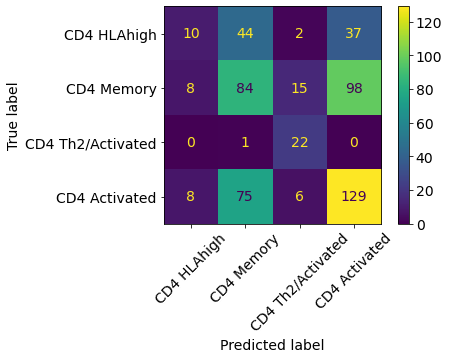

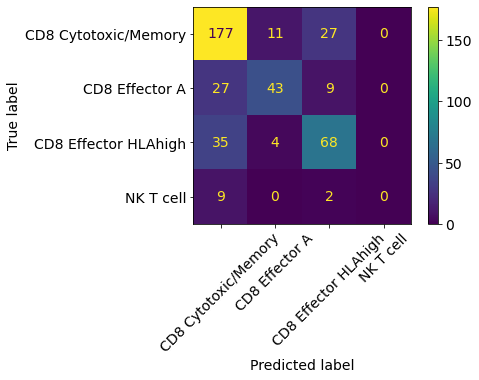

Classification report on the validation set CD8
                   precision    recall  f1-score   support

      CD4 HLAhigh       0.38      0.11      0.17        93
       CD4 Memory       0.41      0.41      0.41       205
CD4 Th2/Activated       0.49      0.96      0.65        23
    CD4 activated       0.49      0.59      0.54       218

         accuracy                           0.45       539
        macro avg       0.44      0.52      0.44       539
     weighted avg       0.44      0.45      0.43       539

Classification report on the validation set CD8
                      precision    recall  f1-score   support

    CD8 Cytox/Memory       0.71      0.82      0.76       215
      CD8 Effector A       0.74      0.54      0.63        79
CD8 Effector HLAhigh       0.64      0.64      0.64       107
           NK T cell       0.00      0.00      0.00        11

            accuracy                           0.70       412
           macro avg       0.52      0.50      0.51    

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [23]:
rf_CD4 = clf_4.best_estimator_
rf_CD8 = clf_8.best_estimator_

rf_CD4.fit(X = training_inputs_10_CD4, y = training_values_CD4)
pred_CD4 = rf_CD4.predict(X = validation_inputs_10_CD4)

rf_CD8.fit(X = training_inputs_10_CD8, y = training_values_CD8)
pred_CD8 = rf_CD8.predict(X = validation_inputs_10_CD8)

# Check what I am predicting with a heatmap of the true counts vs the predicted counts for each class

bincount_pred_CD4 = np.bincount(pred_CD4)
bincount_pred_CD8 = np.bincount(pred_CD8)
bincount_true_CD4 = np.bincount(validation_values_CD4)
bincount_true_CD8 = np.bincount(validation_values_CD8)
if len (bincount_pred_CD8)<8:
    bincount_pred_CD8 = np.asarray(list(bincount_pred_CD8) + [0]) # There may be no NK T cells in the validation set

true_counts_CD4 = pd.DataFrame({"CD4 HLAhigh": bincount_true_CD4[0],
                                "CD4 Memory": bincount_true_CD4[1],
                                "CD4 TH2/Activated": bincount_true_CD4[2],
                                "CD4 activated": bincount_true_CD4[3]
                               
                               }, index = [1])
true_counts_CD8 = pd.DataFrame({"CD8 Cytox/Memory": bincount_true_CD8[4],
                                "CD8 Effector A": bincount_true_CD8[5],
                                "CD8 Effector HLAhigh": bincount_true_CD8[6],
                                "NK T cell": bincount_true_CD8[7]                               
                               }, index = [1])


pred_counts_CD4 = pd.DataFrame({"CD4 HLAhigh": bincount_pred_CD4[0],
                                "CD4 Memory": bincount_pred_CD4[1],
                                "CD4 TH2/Activated": bincount_pred_CD4[2],
                                "CD4 Activated": bincount_pred_CD4[3]
                               
                               }, index = [1])

pred_counts_CD8 = pd.DataFrame({"CD8 Cytotoxic/Memory": bincount_pred_CD8[4],
                                "CD8 Effector A": bincount_pred_CD8[5],
                                "CD8 Effector HLAhigh": bincount_pred_CD8[6],
                                "NK T cell": bincount_pred_CD8[7]                               
                               }, index = [1])

cm_CD4 = sklearn.metrics.confusion_matrix(validation_values_CD4, pred_CD4, labels=[0,1,2,3])
disp_CD4 = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_CD4,
                              display_labels=cell_functions[0:4])
disp_CD4.plot()
disp_CD4.ax_.set_xticklabels(disp_CD4.ax_.get_xmajorticklabels(), rotation=45)
plt.show()


cm_CD8 = sklearn.metrics.confusion_matrix(validation_values_CD8, pred_CD8, labels=[4,5,6,7])
disp_CD8 = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_CD8,
                              display_labels=cell_functions[4:8])

disp_CD8.plot()
disp_CD8.ax_.set_xticklabels(disp_CD8.ax_.get_xmajorticklabels(), rotation = 45)
plt.show()

print("Classification report on the validation set CD8") 
print(classification_report(validation_values_CD4, pred_CD4, target_names=CD4_functions,
                            zero_division="warn" ))

print("Classification report on the validation set CD8") 
print(classification_report(validation_values_CD8, pred_CD8, target_names=CD8_functions,
                            zero_division="warn" ))

CD4_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_true = validation_values_CD4, y_pred = pred_CD4)
CD8_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_true = validation_values_CD8, y_pred = pred_CD8)

print(f"Balanced accuracy: CD4: {CD4_balanced_accuracy}, CD8:{CD8_balanced_accuracy}")

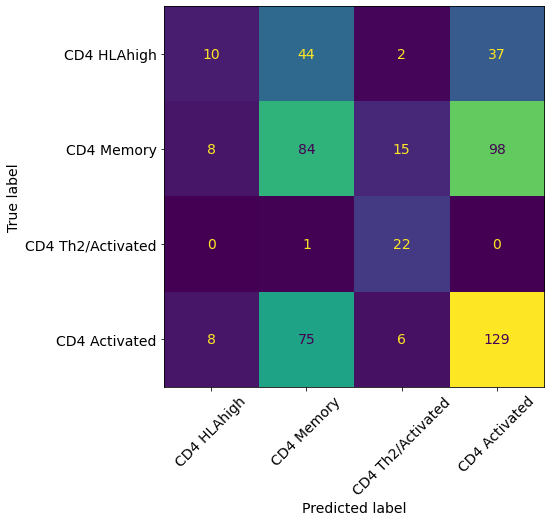

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
disp_CD4.plot(ax = ax, colorbar=False)
disp_CD4.ax_.set_xticklabels(disp_CD4.ax_.get_xmajorticklabels(), rotation=45)
plt.show()

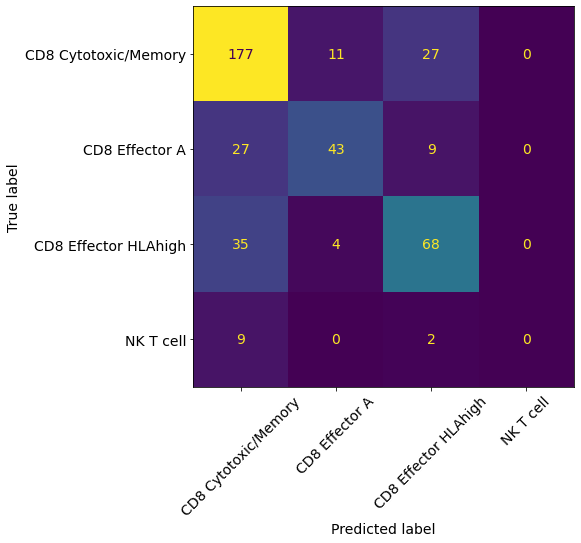

In [25]:
fig, ax = plt.subplots(figsize=(7,7))
disp_CD8.plot(ax = ax, colorbar=False)
disp_CD8.ax_.set_xticklabels(disp_CD8.ax_.get_xmajorticklabels(),rotation=45)
plt.show()



# Classification from Transcription Factor log1p-transformed expression

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [27]:
TFs = pickle.load(open("../../CAR_data/TF_list", "rb"))
TFs.remove("AP1")

In [28]:
sorted(TFs)

['ATF1',
 'ATF2',
 'BCL3',
 'Bcl2',
 'BclXL',
 'CEBPB',
 'CEBPZ',
 'E2F4',
 'ELK1',
 'ELK4',
 'ESR1',
 'ETS1',
 'FOS',
 'FOSL1',
 'FOSL2',
 'GABPA',
 'GADS',
 'GATA1',
 'GATA2',
 'HSF1',
 'IFNG',
 'IL2',
 'IL6',
 'IRF3',
 'JUN',
 'JUND',
 'MEF2A',
 'MEF2C',
 'MYC',
 'NANOG',
 'NFAT',
 'NFAT',
 'NFATC1',
 'REST',
 'RXRA',
 'SP1',
 'STAT1',
 'STAT3',
 'STAT5',
 'TAL1',
 'TNFa',
 'cmyc',
 'mTOR']

In [50]:
expression_sc = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes.csv")


## Used to test if we can predict domain names from the TF expression
expression_sc["encoding_10"] = expression_sc["CAR_Variant"].apply(encode_domain, args = (True,))
# Create a one-digit encoding for the LogReg
all_dom =[]
for i in expression_sc["encoding_10"]:
    if not i in all_dom:
        all_dom.append(i)
for i in expression_sc.index:
    expression_sc.loc[i,"encoding_10"] = all_dom.index(expression_sc.loc[i,"encoding_10"])
        


cell_functions= list(np.unique(expression_sc["cell_type"]))
cell_functions[3] = "CD4 Activated"
cell_functions[4] = "CD8 Cytotoxic/Memory"
print(cell_functions)

expression_sc["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function, args=(cell_functions_list, ))

expression_sc_CD4 = expression_sc[expression_sc["Type"]  == 'CD4']
expression_sc_CD8 = expression_sc[expression_sc["Type"]  == 'CD8']
# Resplit with same seed
[training_sc_CD4, validation_sc_CD4] = train_test_split(expression_sc_CD4, test_size= 0.2, random_state = 1)
[training_sc_CD8, validation_sc_CD8] = train_test_split(expression_sc_CD8, test_size= 0.2, random_state = 1)

# Check that we have all the domains in the training data
n_tot = len(np.unique(expression_sc["CAR_Variant"]))
n_CD4 = len(np.unique(training_sc_CD4["CAR_Variant"]))
n_CD8 = len(np.unique(training_sc_CD8["CAR_Variant"]))
print(f"Total number of CAR variants: {n_tot}")
print(f"number of different CAR variants in the CD4 training set: {n_CD4}")
print(f"number of different CAR variants in the CD8 training set: {n_CD8}")      



['CD4 HLAhigh', 'CD4 Memory', 'CD4 Th2/Activated', 'CD4 Activated', 'CD8 Cytotoxic/Memory', 'CD8 Effector A', 'CD8 Effector HLAhigh', 'NK T cell']
Total number of CAR variants: 31
number of different CAR variants in the CD4 training set: 31
number of different CAR variants in the CD8 training set: 30


In [30]:
rf_class_CD4 = RandomForestClassifier(random_state=2)
rf_class_CD4.fit(X = training_sc_CD4[TFs], y = training_sc_CD4["function_encoded"])

y_pred_test = rf_class_CD4.predict(X = validation_sc_CD4[TFs])
y_pred_train = rf_class_CD4.predict(X = training_sc_CD4[TFs])

score_test = balanced_accuracy_score(y_true = validation_sc_CD4["function_encoded"],
                              y_pred = y_pred_test
                             )
score_train = balanced_accuracy_score(y_true = training_sc_CD4["function_encoded"],
                              y_pred = y_pred_train
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(validation_sc_CD4["function_encoded"], y_pred_test, target_names=cell_functions[0:4],
                            zero_division="warn" ))

 Mean accuracy: train = 1.0, 
 Mean accuracy: test = 0.4898377618984703
Classification report
                   precision    recall  f1-score   support

      CD4 HLAhigh       0.50      0.39      0.44        93
       CD4 Memory       0.70      0.79      0.74       205
CD4 Th2/Activated       1.00      0.04      0.08        23
    CD4 Activated       0.68      0.74      0.71       218

         accuracy                           0.67       539
        macro avg       0.72      0.49      0.49       539
     weighted avg       0.67      0.67      0.65       539



In [31]:
rf_class_CD8 = RandomForestClassifier(random_state=2)
rf_class_CD8.fit(X = training_sc_CD8[TFs], y = training_sc_CD8["function_encoded"])

y_pred_test = rf_class_CD8.predict(X = validation_sc_CD8[TFs])
y_pred_train = rf_class_CD8.predict(X = training_sc_CD8[TFs])

score_test = balanced_accuracy_score(y_true = validation_sc_CD8["function_encoded"],
                              y_pred = y_pred_test
                             )
score_train = balanced_accuracy_score(y_true = training_sc_CD8["function_encoded"],
                              y_pred = y_pred_train
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(validation_sc_CD8["function_encoded"], y_pred_test, target_names=cell_functions[4:8],
                            zero_division="warn" ))

 Mean accuracy: train = 1.0, 
 Mean accuracy: test = 0.5126485986810793
Classification report
                      precision    recall  f1-score   support

CD8 Cytotoxic/Memory       0.71      0.91      0.80       215
      CD8 Effector A       0.75      0.62      0.68        79
CD8 Effector HLAhigh       0.77      0.52      0.62       107
           NK T cell       0.00      0.00      0.00        11

            accuracy                           0.73       412
           macro avg       0.56      0.51      0.53       412
        weighted avg       0.72      0.73      0.71       412



/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [32]:
scaler_CD4 = MinMaxScaler()
X_scaled_CD4 = training_sc_CD4.copy()
X_test_scaled_CD4 = validation_sc_CD4.copy()
X_scaled_CD4[TFs ] = scaler_CD4.fit_transform(training_sc_CD4[TFs])
X_test_scaled_CD4[TFs ] = scaler_CD4.transform(validation_sc_CD4[TFs])

scaler_CD8 = MinMaxScaler()
X_scaled_CD8 = training_sc_CD8.copy()
X_test_scaled_CD8 = validation_sc_CD8.copy()
X_scaled_CD8[TFs] = scaler_CD8.fit_transform(training_sc_CD8[TFs])
X_test_scaled_CD8[TFs] = scaler_CD8.transform(validation_sc_CD8[TFs])


 Mean accuracy: train = 0.5503175047429165, 
 Mean accuracy: test = 0.5437754748283615
Classification report
                   precision    recall  f1-score   support

      CD4 HLAhigh       0.53      0.44      0.48        93
       CD4 Memory       0.70      0.71      0.70       205
CD4 Th2/Activated       0.86      0.26      0.40        23
    CD4 Activated       0.68      0.77      0.72       218

         accuracy                           0.67       539
        macro avg       0.69      0.54      0.58       539
     weighted avg       0.67      0.67      0.66       539



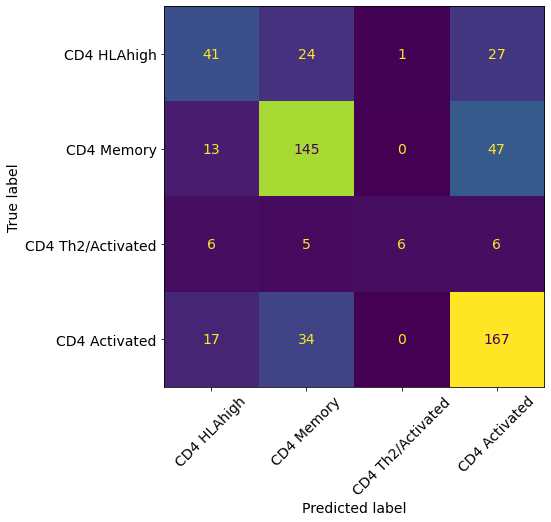

In [33]:
rf_class = LogisticRegression(random_state=2)
rf_class.fit(X = X_scaled_CD4[TFs], y = X_scaled_CD4["function_encoded"])

y_pred_test_CD4 = rf_class.predict(X = X_test_scaled_CD4[TFs])
y_pred_train_CD4 = rf_class.predict(X = X_scaled_CD4[TFs])

score_test = balanced_accuracy_score(y_true = X_test_scaled_CD4["function_encoded"],
                              y_pred = y_pred_test_CD4
                             )
score_train = balanced_accuracy_score(y_true = X_scaled_CD4["function_encoded"],
                              y_pred = y_pred_train_CD4
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(X_test_scaled_CD4["function_encoded"], y_pred_test_CD4, target_names=cell_functions[0:4],
                            zero_division="warn" ))

fig, ax = plt.subplots(figsize=(7, 7))
cm = sklearn.metrics.confusion_matrix(X_test_scaled_CD4["function_encoded"], y_pred_test_CD4, labels=[0,1,2,3])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cell_functions[0:4])
disp.plot(ax = ax, colorbar=False)
disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), rotation = 45)

plt.show()

 Mean accuracy: train = 1.0, 
 Mean accuracy: test = 0.5126485986810793
Classification report
                      precision    recall  f1-score   support

CD8 Cytotoxic/Memory       0.71      0.84      0.77       215
      CD8 Effector A       0.75      0.65      0.69        79
CD8 Effector HLAhigh       0.68      0.57      0.62       107
           NK T cell       0.00      0.00      0.00        11

            accuracy                           0.71       412
           macro avg       0.54      0.51      0.52       412
        weighted avg       0.69      0.71      0.70       412



/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

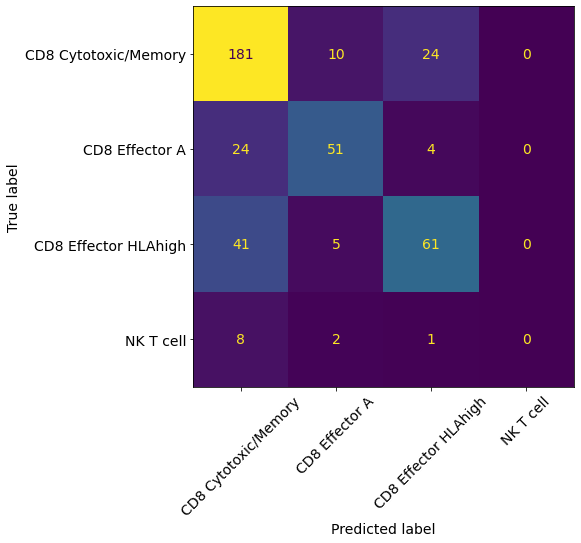

In [34]:
rf_class = LogisticRegression(random_state=2)
rf_class.fit(X = X_scaled_CD8[TFs], y = X_scaled_CD8["function_encoded"])

y_pred_test_CD8 = rf_class.predict(X = X_test_scaled_CD8[TFs])
y_pred_train_CD8 = rf_class.predict(X = X_scaled_CD8[TFs])

score_test = balanced_accuracy_score(y_true = X_test_scaled_CD8["function_encoded"],
                              y_pred = y_pred_test
                             )
score_train = balanced_accuracy_score(y_true = X_scaled_CD8["function_encoded"],
                              y_pred = y_pred_train
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(X_test_scaled_CD8["function_encoded"], y_pred_test_CD8, target_names=cell_functions[4:8],
                            zero_division="warn" ))

fig, ax = plt.subplots(figsize=(7, 7))
cm = sklearn.metrics.confusion_matrix(X_test_scaled_CD8["function_encoded"], y_pred_test_CD8, labels=[4, 5, 6, 7])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cell_functions[4:8])
disp.plot(ax = ax, colorbar=False)
disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), rotation = 45)

plt.show()

In [35]:
CD4_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_true = X_test_scaled_CD4["function_encoded"], y_pred = y_pred_test_CD4)
CD8_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_true = X_test_scaled_CD8["function_encoded"], y_pred = y_pred_test_CD8)

print(f"Balanced accuracy: CD4: {CD4_balanced_accuracy}, CD8:{CD8_balanced_accuracy}")

Balanced accuracy: CD4: 0.5437754748283615, CD8:0.5143808858283423


## Run a GridSearch for completeness

In [36]:
log_reg_params = {"penalty": [None, "l1", "l2"],
                  "C": [1, 0.1, 0.01, 0.001],
                  "class_weight": [None, "balanced"], 
                  "max_iter": [100,500, 800],
                  "multi_class": ["multinomial"],
                  "solver": ["lbfgs", "saga"]
                 }

logreg_4 = GridSearchCV(LogisticRegression(random_state=2), log_reg_params, verbose = 4, 
                        scoring = ["balanced_accuracy", "accuracy"], refit = "accuracy")
logreg_4.fit(X_scaled_CD4[TFs], X_scaled_CD4["function_encoded"])

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=mult

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.691) balanced_accuracy: (test=0.553) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.668) balanced_accuracy: (test=0.575) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.677) balanced_accuracy: (test=0.573) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.694) balanced_accuracy: (test=0.557) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.651) balanced_accuracy: (test=0.501) total time=   0.4s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.680) balanced_accuracy: (test=0.515) total time=   0.1s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.647) balanced_accuracy: (test=0.521) total time=   0.1s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.675) balanced_accuracy: (test=0.545) total time=   0.1s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.696) balanced_accuracy: (test=0.559) total time=   0.1s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.6

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.668) balanced_accuracy: (test=0.575) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.677) balanced_accuracy: (test=0.573) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.694) balanced_accuracy: (test=0.557) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.651) balanced_accuracy: (test=0.501) total time=   1.6s
[CV 1/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.680) balanced_accuracy: (test=0.515) total time=   0.1s
[CV 2/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.647) balanced_accuracy: (test=0.521) total time=   0.1s
[CV 3/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.675) balanced_accuracy: (test=0.545) total time=   0.1s
[CV 4/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.696) balanced_accuracy: (test=0.559) total time=   0.1s
[CV 5/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.6

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.668) balanced_accuracy: (test=0.575) total time=   2.9s
[CV 3/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.677) balanced_accuracy: (test=0.573) total time=   1.8s
[CV 4/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.694) balanced_accuracy: (test=0.557) total time=   2.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.651) balanced_accuracy: (test=0.501) total time=   2.7s
[CV 1/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.680) balanced_accuracy: (test=0.515) total time=   0.1s
[CV 2/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.647) balanced_accuracy: (test=0.521) total time=   0.1s
[CV 3/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.675) balanced_accuracy: (test=0.545) total time=   0.1s
[CV 4/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.696) balanced_accuracy: (test=0.559) total time=   0.1s
[CV 5/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.6

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.660) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.615) balanced_accuracy: (test=0.665) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.675) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.341) balanced_accuracy: (test=0.347) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.605) balanced_accuracy: (test=0.600) total time=   0.3s
[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.657) balanced_accuracy: (test=0.664) total time=   0.1s
[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.622) balanced_accuracy: (test=0.675) total time=   0.1s
[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.633) balanced_accuracy: (test=0.666) total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.654) balanced_accuracy: (test=0.670) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.623) balanced_accuracy: (test=0.608) total time=   0.3s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; a

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.660) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.626) balanced_accuracy: (test=0.608) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.636) balanced_accuracy: (test=0.622) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.624) balanced_accuracy: (test=0.668) total time=   1.8s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.616) balanced_accuracy: (test=0.592) total time=   1.8s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.657) balanced_accuracy: (test=0.664) total time=   0.1s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.622) balanced_accuracy: (test=0.675) total time=   0.1s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.633) balanced_accuracy: (test=0.666) total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.654) balanced_accuracy: (test=0.670) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.660) total time=   2.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.608) balanced_accuracy: (test=0.663) total time=   2.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.629) balanced_accuracy: (test=0.668) total time=   2.8s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.661) balanced_accuracy: (test=0.689) total time=   2.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.614) balanced_accuracy: (test=0.583) total time=   2.7s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.657) balanced_accuracy: (test=0.664) total time=   0.1s
[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.622) balanced_accuracy: (test=0.675) total time=   0.1s
[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.633) balanced_accuracy: (test=0.666) total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.654) balanced_accuracy: (test=0.670) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.439) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.638) balanced_accuracy: (test=0.443) total time=   0.3s
[CV 3/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.633) balanced_accuracy: (test=0.442) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.659) balanced_accuracy: (test=0.459) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.633) balanced_accuracy: (test=0.441) total time=   0.3s
[CV 1/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.671) balanced_accuracy: (test=0.471) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.654) balanced_accuracy: (test=0.468) total time=   0.1s
[CV 3/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.652) balanced_accuracy: (test=0.464) total time=   0.1s
[CV 4/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.680) balanced_accuracy: (test=0.487) total time=   0.1s
[CV 5/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accurac

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.439) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.638) balanced_accuracy: (test=0.443) total time=   1.6s
[CV 3/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.633) balanced_accuracy: (test=0.442) total time=   0.3s
[CV 4/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.659) balanced_accuracy: (test=0.459) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.635) balanced_accuracy: (test=0.443) total time=   1.7s
[CV 1/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.671) balanced_accuracy: (test=0.471) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.654) balanced_accuracy: (test=0.468) total time=   0.1s
[CV 3/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.652) balanced_accuracy: (test=0.464) total time=   0.1s
[CV 4/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.680) balanced_accuracy: (test=0.487) total time=   0.1s
[CV 5/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accurac

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.635) balanced_accuracy: (test=0.443) total time=   2.5s
[CV 1/5] END C=0.1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.671) balanced_accuracy: (test=0.471) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.654) balanced_accuracy: (test=0.468) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.652) balanced_accuracy: (test=0.464) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.680) balanced_accuracy: (test=0.487) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accurac

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.629) balanced_accuracy: (test=0.652) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.594) balanced_accuracy: (test=0.642) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.585) balanced_accuracy: (test=0.642) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.626) balanced_accuracy: (test=0.673) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.602) balanced_accuracy: (test=0.587) total time=   0.3s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.661) balanced_accuracy: (test=0.650) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.603) balanced_accuracy: (test=0.659) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.636) balanced_accuracy: (test=0.680) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.652) balanced_accuracy: (test=0.690) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.602) balanced_accuracy: (test=0.587) total time=   1.6s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.661) balanced_accuracy: (test=0.650) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.603) balanced_accuracy: (test=0.659) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.636) balanced_accuracy: (test=0.680) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.652) balanced_accuracy: (test=0.690) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l

[CV 2/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.606) balanced_accuracy: (test=0.389) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.619) balanced_accuracy: (test=0.398) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.617) balanced_accuracy: (test=0.399) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.605) balanced_accuracy: (test=0.389) total time=   0.0s
[CV 1/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.640) balanced_accuracy: (test=0.412) total time=   0.1s
[CV 2/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; ac

[CV 3/5] END C=0.01, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.619) balanced_accuracy: (test=0.398) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.617) balanced_accuracy: (test=0.399) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.605) balanced_accuracy: (test=0.389) total time=   0.0s
[CV 1/5] END C=0.01, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.640) balanced_accuracy: (test=0.412) total time=   0.1s
[CV 2/5] END C=0.01, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.606) balanced_accuracy: (test=0.389) total time=   0.1s
[CV 3/5] END C=0.01, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; acc

[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.636) balanced_accuracy: (test=0.668) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.629) balanced_accuracy: (test=0.659) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.609) balanced_accuracy: (test=0.563) total time=   0.0s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.664) balanced_accuracy: (test=0.652) total time=   0.1s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.580) balanced_accuracy: (test=0.615) total time=   0.1s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, pena

[CV 1/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.589) balanced_accuracy: (test=0.377) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.564) balanced_accuracy: (test=0.360) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.571) balanced_accuracy: (test=0.365) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.601) balanced_accuracy: (test=0.386) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.593) balanced_accuracy: (test=0.380) total time=   0.0s
[CV 1/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfg

[CV 1/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.589) balanced_accuracy: (test=0.377) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.564) balanced_accuracy: (test=0.360) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.571) balanced_accuracy: (test=0.365) total time=   0.1s
[CV 4/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.601) balanced_accuracy: (test=0.386) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.593) balanced_accuracy: (test=0.380) total time=   0.1s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=None, solver=

[CV 2/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.585) balanced_accuracy: (test=0.611) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.622) balanced_accuracy: (test=0.648) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.626) balanced_accuracy: (test=0.646) total time=   0.1s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.600) balanced_accuracy: (test=0.549) total time=   0.1s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, pe

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib

GridSearchCV(estimator=LogisticRegression(random_state=2),
             param_grid={'C': [1, 0.1, 0.01, 0.001],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [100, 500, 800],
                         'multi_class': ['multinomial'],
                         'penalty': [None, 'l1', 'l2'],
                         'solver': ['lbfgs', 'saga']},
             refit='accuracy', scoring=['balanced_accuracy', 'accuracy'],
             verbose=4)

In [37]:
logreg_8 = GridSearchCV(LogisticRegression(random_state=2), log_reg_params, verbose = 4, 
                        scoring = ["balanced_accuracy", "accuracy"], refit = "accuracy")
logreg_8.fit(X_scaled_CD8[TFs], X_scaled_CD8["function_encoded"])

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=mult

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.638) balanced_accuracy: (test=0.474) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.702) balanced_accuracy: (test=0.501) total time=   0.2s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.742) balanced_accuracy: (test=0.548) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.684) balanced_accuracy: (test=0.502) total time=   0.3s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.642) balanced_accuracy: (test=0.474) total time=   0.0s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.650) balanced_accuracy: (test=0.481) total time=   0.0s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.684) balanced_accuracy: (test=0.478) total time=   0.0s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.736) balanced_accuracy: (test=0.540) total time=   0.0s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.7

[CV 1/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.645) balanced_accuracy: (test=0.477) total time=   0.2s
[CV 2/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.638) balanced_accuracy: (test=0.474) total time=   0.5s
[CV 3/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.702) balanced_accuracy: (test=0.501) total time=   0.8s
[CV 4/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.742) balanced_accuracy: (test=0.548) total time=   0.2s
[CV 5/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.684) balanced_accuracy: (test=0.502) total time=   0.5s
[CV 1/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.642) 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.570) balanced_accuracy: (test=0.539) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.541) balanced_accuracy: (test=0.446) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.544) balanced_accuracy: (test=0.568) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.614) balanced_accuracy: (test=0.542) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.581) balanced_accuracy: (test=0.634) total time=   0.3s
[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.591) balanced_accuracy: (test=0.556) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.520) balanced_accuracy: (test=0.518) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.611) balanced_accuracy: (test=0.621) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.617) balanced_accuracy: (test=0.534) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.465) balanced_accuracy: (test=0.477) total time=   0.2s
[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.584) balanced_accuracy: (test=0.596) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.647) balanced_accuracy: (test=0.597) total time=   0.2s
[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.623) balanced_accuracy: (test=0.654) total time=   0.2s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=saga; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=saga; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=saga; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=saga; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=saga; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=lbfgs; accuracy:

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.624) balanced_accuracy: (test=0.495) total time=   1.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.474) balanced_accuracy: (test=0.375) total time=   1.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.489) balanced_accuracy: (test=0.545) total time=   1.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.599) balanced_accuracy: (test=0.469) total time=   1.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.362) balanced_accuracy: (test=0.510) total time=   1.3s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.591) balanced_accuracy: (test=0.556) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.520) balanced_accuracy: (test=0.518) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.611) balanced_accuracy: (test=0.621) total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.617) balanced_accuracy: (test=0.534) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.518) balanced_accuracy: (test=0.486) total time=   1.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.508) balanced_accuracy: (test=0.408) total time=   1.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.568) balanced_accuracy: (test=0.589) total time=   1.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.684) balanced_accuracy: (test=0.563) total time=   1.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.541) balanced_accuracy: (test=0.467) total time=   1.0s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; a

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.570) balanced_accuracy: (test=0.539) total time=   2.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.465) balanced_accuracy: (test=0.473) total time=   2.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.629) balanced_accuracy: (test=0.547) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.450) balanced_accuracy: (test=0.539) total time=   2.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.574) balanced_accuracy: (test=0.628) total time=   2.4s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.591) balanced_accuracy: (test=0.556) total time=   0.1s
[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.520) balanced_accuracy: (test=0.518) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.611) balanced_accuracy: (test=0.621) total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.617) balanced_accuracy: (test=0.534) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.564) balanced_accuracy: (test=0.541) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.568) balanced_accuracy: (test=0.461) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.641) balanced_accuracy: (test=0.503) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.669) balanced_accuracy: (test=0.567) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.632) balanced_accuracy: (test=0.615) total time=   1.6s
[CV 1/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (

[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.602) balanced_accuracy: (test=0.395) total time=   0.1s
[CV 3/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.614) balanced_accuracy: (test=0.388) total time=   0.1s
[CV 4/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.626) balanced_accuracy: (test=0.413) total time=   0.1s
[CV 5/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.629) balanced_accuracy: (test=0.410) total time=   0.1s
[CV 1/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.609) balanced_accuracy: (test=0.414) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.215) balanced_accuracy: (test=0.341) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.422) balanced_accuracy: (test=0.422) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.480) balanced_accuracy: (test=0.595) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.511) balanced_accuracy: (test=0.452) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.392) balanced_accuracy: (test=0.537) total time=   0.3s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.570) balanced_accuracy: (test=0.508) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.514) balanced_accuracy: (test=0.471) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.556) balanced_accuracy: (test=0.643) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.584) balanced_accuracy: (test=0.518) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.348) balanced_accuracy: (test=0.352) total time=   0.2s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.505) balanced_accuracy: (test=0.513) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.571) balanced_accuracy: (test=0.577) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.599) balanced_accuracy: (test=0.532) total time=   0.2s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.623) balanced_accuracy: (test=0.657) total time=   0.2s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, so

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.361) balanced_accuracy: (test=0.279) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.508) balanced_accuracy: (test=0.444) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.523) balanced_accuracy: (test=0.398) total time=   1.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.018) balanced_accuracy: (test=0.250) total time=   1.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.584) balanced_accuracy: (test=0.482) total time=   1.4s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.570) balanced_accuracy: (test=0.508) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.514) balanced_accuracy: (test=0.471) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.556) balanced_accuracy: (test=0.643) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.584) balanced_accuracy: (test=0.518) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.397) balanced_accuracy: (test=0.331) total time=   0.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.505) balanced_accuracy: (test=0.506) total time=   0.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.024) balanced_accuracy: (test=0.263) total time=   1.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.653) balanced_accuracy: (test=0.524) total time=   0.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.641) balanced_accuracy: (test=0.670) total time=   0.9s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, sol

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.545) balanced_accuracy: (test=0.459) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.389) balanced_accuracy: (test=0.514) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.529) balanced_accuracy: (test=0.494) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.356) balanced_accuracy: (test=0.473) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.508) balanced_accuracy: (test=0.514) total time=   2.4s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.570) balanced_accuracy: (test=0.508) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.514) balanced_accuracy: (test=0.471) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.556) balanced_accuracy: (test=0.643) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.584) balanced_accuracy: (test=0.518) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.555) balanced_accuracy: (test=0.453) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.508) balanced_accuracy: (test=0.565) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.529) balanced_accuracy: (test=0.625) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.562) balanced_accuracy: (test=0.536) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.641) balanced_accuracy: (test=0.670) total time=   1.6s
[CV 1/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accu

[CV 2/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.498) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.502) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.498) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.498) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 1/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.497) balanced_accuracy: (test=0.251) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accu

[CV 1/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.561) balanced_accuracy: (test=0.471) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.514) balanced_accuracy: (test=0.488) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.544) balanced_accuracy: (test=0.595) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.574) balanced_accuracy: (test=0.530) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.590) balanced_accuracy: (test=0.613) total time=   0.0s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, pe

[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.173) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.307) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.307) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.561) balanced_accuracy: (test=0.471) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.514) balanced_accuracy: (test=0.488) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penal

[CV 2/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.498) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.502) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.498) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.498) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 1/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.497) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=sa

[CV 4/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.307) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.018) balanced_accuracy: (test=0.250) total time=   0.0s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.561) balanced_accuracy: (test=0.478) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.505) balanced_accuracy: (test=0.488) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.541) balanced_accuracy: (test=0.602) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial

[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.505) balanced_accuracy: (test=0.488) total time=   0.1s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.541) balanced_accuracy: (test=0.602) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.550) balanced_accuracy: (test=0.517) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.574) balanced_accuracy: (test=0.612) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib

GridSearchCV(estimator=LogisticRegression(random_state=2),
             param_grid={'C': [1, 0.1, 0.01, 0.001],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [100, 500, 800],
                         'multi_class': ['multinomial'],
                         'penalty': [None, 'l1', 'l2'],
                         'solver': ['lbfgs', 'saga']},
             refit='accuracy', scoring=['balanced_accuracy', 'accuracy'],
             verbose=4)

In [38]:
logreg_4.best_estimator_

LogisticRegression(C=1, multi_class='multinomial', penalty='l1', random_state=2,
                   solver='saga')

In [39]:
logreg_8.best_estimator_

LogisticRegression(C=1, multi_class='multinomial', random_state=2)

 Mean accuracy: train = 0.5796889570083379, 
 Mean accuracy: test = 0.553747398707694
Classification report
                   precision    recall  f1-score   support

      CD4 HLAhigh       0.53      0.45      0.49        93
       CD4 Memory       0.70      0.70      0.70       205
CD4 Th2/Activated       0.88      0.30      0.45        23
    CD4 Activated       0.67      0.76      0.71       218

         accuracy                           0.66       539
        macro avg       0.69      0.55      0.59       539
     weighted avg       0.67      0.66      0.66       539



/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


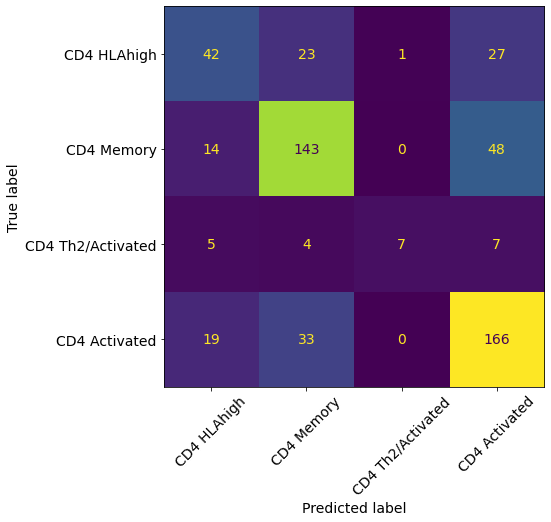

In [40]:
rf_class =logreg_4.best_estimator_
rf_class.fit(X = X_scaled_CD4[TFs], y = X_scaled_CD4["function_encoded"])

y_pred_test_CD4 = rf_class.predict(X = X_test_scaled_CD4[TFs])
y_pred_train_CD4 = rf_class.predict(X = X_scaled_CD4[TFs])

score_test = balanced_accuracy_score(y_true = X_test_scaled_CD4["function_encoded"],
                              y_pred = y_pred_test_CD4
                             )
score_train = balanced_accuracy_score(y_true = X_scaled_CD4["function_encoded"],
                              y_pred = y_pred_train_CD4
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(X_test_scaled_CD4["function_encoded"], y_pred_test_CD4, target_names=cell_functions[0:4],
                            zero_division="warn" ))

fig, ax = plt.subplots(figsize=(7, 7))
cm = sklearn.metrics.confusion_matrix(X_test_scaled_CD4["function_encoded"], y_pred_test_CD4, labels=[0,1,2,3])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cell_functions[0:4])
disp.plot(ax = ax, colorbar=False)
disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), rotation = 45)

plt.show()

 Mean accuracy: train = 1.0, 
 Mean accuracy: test = 0.5126485986810793
Classification report
                      precision    recall  f1-score   support

CD8 Cytotoxic/Memory       0.71      0.84      0.77       215
      CD8 Effector A       0.75      0.65      0.69        79
CD8 Effector HLAhigh       0.68      0.57      0.62       107
           NK T cell       0.00      0.00      0.00        11

            accuracy                           0.71       412
           macro avg       0.54      0.51      0.52       412
        weighted avg       0.69      0.71      0.70       412



/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

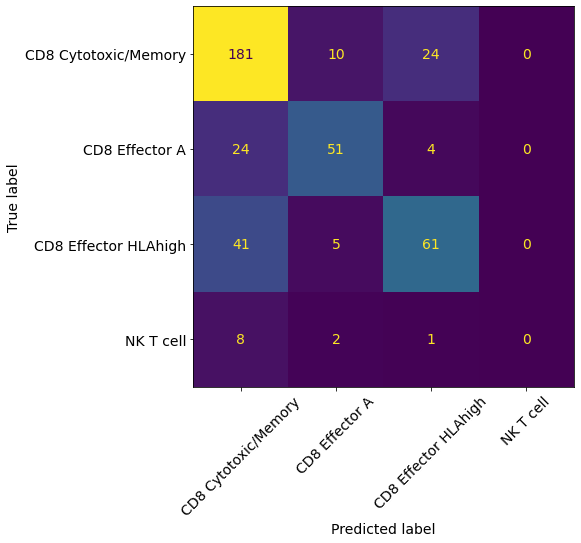

In [41]:
rf_class = logreg_8.best_estimator_
rf_class.fit(X = X_scaled_CD8[TFs], y = X_scaled_CD8["function_encoded"])

y_pred_test_CD8 = rf_class.predict(X = X_test_scaled_CD8[TFs])
y_pred_train_CD8 = rf_class.predict(X = X_scaled_CD8[TFs])

score_test = balanced_accuracy_score(y_true = X_test_scaled_CD8["function_encoded"],
                              y_pred = y_pred_test
                             )
score_train = balanced_accuracy_score(y_true = X_scaled_CD8["function_encoded"],
                              y_pred = y_pred_train
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(X_test_scaled_CD8["function_encoded"], y_pred_test_CD8, target_names=cell_functions[4:8],
                            zero_division="warn" ))

fig, ax = plt.subplots(figsize=(7, 7))
cm = sklearn.metrics.confusion_matrix(X_test_scaled_CD8["function_encoded"], y_pred_test_CD8, labels=[4, 5, 6, 7])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cell_functions[4:8])
disp.plot(ax = ax, colorbar=False)
disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), rotation = 45)

plt.show()

# Reverse goal: predict the CAR domain from the transcription factor expression

In [42]:
"""PREDICT CAR FROM TF CD4"""

training_domains_10_CD4 =  np.asarray(list(training_sc_CD4["encoding_10"]))
validation_domains_10_CD4 =  np.asarray(list(validation_sc_CD4["encoding_10"]))

training_domains_10_CD8 =  np.asarray(list(training_sc_CD8["encoding_10"]))
validation_domains_10_CD8 =  np.asarray(list(validation_sc_CD8["encoding_10"]))




rf_class_4 = LogisticRegression(random_state=2)
rf_class_4.fit(X = X_scaled_CD4[TFs], y = training_domains_10_CD4)

y_pred_test_CD4 = rf_class_4.predict(X = X_test_scaled_CD4[TFs])
y_pred_train_CD4 = rf_class_4.predict(X = X_scaled_CD4[TFs])

score_test = balanced_accuracy_score(y_true = validation_domains_10_CD4,
                              y_pred = y_pred_test_CD4
                             )
score_train = balanced_accuracy_score(y_true = training_domains_10_CD4,
                              y_pred = y_pred_train_CD4
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(validation_domains_10_CD4, y_pred_test_CD4, 
                            zero_division="warn" ))


 Mean accuracy: train = 0.09857449187234196, 
 Mean accuracy: test = 0.06286909457255024
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.09      0.14      0.11        36
           2       0.17      0.08      0.11        26
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.10      0.23      0.14        26
           6       0.06      0.07      0.06        29
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        22
          14       0.00      0.00      0.00         7
          15       0.09 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [43]:
rf_class_8 = LogisticRegression(random_state=2)
rf_class_8.fit(X = X_scaled_CD8[TFs], y = training_domains_10_CD8)

y_pred_test_CD8 = rf_class_8.predict(X = X_test_scaled_CD8[TFs])
y_pred_train_CD8 = rf_class_8.predict(X = X_scaled_CD8[TFs])

score_test = balanced_accuracy_score(y_true = validation_domains_10_CD8,
                              y_pred = y_pred_test_CD8
                             )
score_train = balanced_accuracy_score(y_true = training_domains_10_CD8,
                              y_pred = y_pred_train_CD8
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(validation_domains_10_CD8, y_pred_test_CD8, 
                            zero_division="warn" ))



 Mean accuracy: train = 0.11779355701235188, 
 Mean accuracy: test = 0.082333184057322
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.12      0.42      0.19        33
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        23
           6       0.17      0.30      0.22        30
           7       0.00      0.00      0.00        10
           8       0.19      0.19      0.19        21
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        29
          12       0.00      0.00      0.00         1
          13       0.12      0.05      0.07        20
          14       0.00      0.00      0.00         9
          15       0.20   

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: Und

In [44]:
logreg_4_CAR = GridSearchCV(LogisticRegression(random_state=2), log_reg_params, verbose = 4, 
                            scoring = ["balanced_accuracy", "accuracy"], refit = "accuracy")
logreg_4_CAR.fit(X_scaled_CD4[TFs], training_domains_10_CD4)

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=mult

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.146) balanced_accuracy: (test=0.069) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.061) total time=   2.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.139) balanced_accuracy: (test=0.063) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.135) balanced_accuracy: (test=0.063) total time=   2.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.147) balanced_accuracy: (test=0.071) total time=   2.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.135) balanced_accuracy: (test=0.061) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.158) balanced_accuracy: (test=0.075) total time=   0.3s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.144) balanced_accuracy: (test=0.067) total time=   0.2s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.139) balanced_accuracy: (test=0.068) total time=   0.2s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.133) balanced_accuracy: (test=0.065) total time=   0.4s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.135) balanced_accuracy: (test=0.061) total time=   1.2s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.15

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.146) balanced_accuracy: (test=0.069) total time=  10.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.061) total time=  10.5s
[CV 3/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.139) balanced_accuracy: (test=0.063) total time=  10.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.135) balanced_accuracy: (test=0.063) total time=  10.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.147) balanced_accuracy: (test=0.071) total time=  10.5s
[CV 1/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.135) balanced_accuracy: (test=0.061) total time=   0.3s
[CV 2/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.158) balanced_accuracy: (test=0.075) total time=   0.3s
[CV 3/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.144) balanced_accuracy: (test=0.067) total time=   0.2s
[CV 4/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.139) balanced_accuracy: (test=0.068) total time=   0.2s
[CV 5/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.1

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.061) total time=  16.7s
[CV 3/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.139) balanced_accuracy: (test=0.063) total time=   9.8s
[CV 4/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.135) balanced_accuracy: (test=0.063) total time=  12.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.147) balanced_accuracy: (test=0.071) total time=  16.8s
[CV 1/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.135) balanced_accuracy: (test=0.061) total time=   0.3s
[CV 2/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.158) balanced_accuracy: (test=0.075) total time=   0.3s
[CV 3/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.144) balanced_accuracy: (test=0.067) total time=   0.2s
[CV 4/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.139) balanced_accuracy: (test=0.068) total time=   0.2s
[CV 5/5] END C=1, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.1

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.093) balanced_accuracy: (test=0.067) total time=   2.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.093) balanced_accuracy: (test=0.070) total time=   2.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.104) balanced_accuracy: (test=0.063) total time=   2.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.056) balanced_accuracy: (test=0.056) total time=   2.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.077) balanced_accuracy: (test=0.072) total time=   2.5s
[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.095) balanced_accuracy: (test=0.070) total time=   0.2s
[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.121) balanced_accuracy: (test=0.124) total time=   0.2s
[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.086) balanced_accuracy: (test=0.057) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.090) balanced_accuracy: (test=0.060) total time=   0.2s
[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.066) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.093) balanced_accuracy: (test=0.100) total time=   1.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.089) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.034) total time=   1.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.016) balanced_accuracy: (test=0.012) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.068) total time=   1.5s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; a

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.090) balanced_accuracy: (test=0.067) total time=  11.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.104) balanced_accuracy: (test=0.089) total time=  11.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.077) balanced_accuracy: (test=0.056) total time=  12.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.086) balanced_accuracy: (test=0.062) total time=  12.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.079) balanced_accuracy: (test=0.078) total time=  11.7s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.095) balanced_accuracy: (test=0.070) total time=   0.2s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.121) balanced_accuracy: (test=0.124) total time=   0.2s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.086) balanced_accuracy: (test=0.057) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.090) balanced_accuracy: (test=0.060) total time=   0.2s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.066) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.071) total time=   7.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.116) balanced_accuracy: (test=0.125) total time=   7.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.079) balanced_accuracy: (test=0.043) total time=   7.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.086) balanced_accuracy: (test=0.058) total time=   7.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.084) balanced_accuracy: (test=0.063) total time=   7.3s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; a

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.093) balanced_accuracy: (test=0.067) total time=  17.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.093) balanced_accuracy: (test=0.070) total time=  18.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.079) balanced_accuracy: (test=0.065) total time=  19.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.086) balanced_accuracy: (test=0.062) total time=  19.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.079) total time=  19.0s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.095) balanced_accuracy: (test=0.070) total time=   0.2s
[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.121) balanced_accuracy: (test=0.124) total time=   0.2s
[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.086) balanced_accuracy: (test=0.057) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.090) balanced_accuracy: (test=0.060) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.066) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.095) balanced_accuracy: (test=0.101) total time=  12.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.118) balanced_accuracy: (test=0.126) total time=  12.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.086) balanced_accuracy: (test=0.057) total time=  12.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.086) balanced_accuracy: (test=0.058) total time=  12.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.086) balanced_accuracy: (test=0.064) total time=  12.3s
[CV 1/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (

[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.132) balanced_accuracy: (test=0.052) total time=   0.3s
[CV 3/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.040) total time=   0.3s
[CV 4/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.121) balanced_accuracy: (test=0.048) total time=   0.3s
[CV 5/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.116) balanced_accuracy: (test=0.047) total time=   0.3s
[CV 1/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.148) balanced_accuracy: (test=0.060) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.007) balanced_accuracy: (test=0.048) total time=   2.2s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.007) balanced_accuracy: (test=0.048) total time=   0.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.007) balanced_accuracy: (test=0.025) total time=   0.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.009) balanced_accuracy: (test=0.019) total time=   0.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.021) balanced_accuracy: (test=0.025) total time=   0.8s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.088) balanced_accuracy: (test=0.097) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.095) balanced_accuracy: (test=0.104) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.070) balanced_accuracy: (test=0.042) total time=   0.1s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.058) balanced_accuracy: (test=0.043) total time=   0.1s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.058) balanced_accuracy: (test=0.051) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.072) balanced_accuracy: (test=0.090) total time=   1.6s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.095) balanced_accuracy: (test=0.104) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.070) balanced_accuracy: (test=0.042) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.058) balanced_accuracy: (test=0.043) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.060) balanced_accuracy: (test=0.052) total time=   0.3s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, sol

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.074) balanced_accuracy: (test=0.032) total time=  10.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.007) balanced_accuracy: (test=0.048) total time=   0.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.007) balanced_accuracy: (test=0.025) total time=   0.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.009) balanced_accuracy: (test=0.019) total time=   0.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.021) balanced_accuracy: (test=0.025) total time=   0.8s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.088) balanced_accuracy: (test=0.097) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.095) balanced_accuracy: (test=0.104) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.070) balanced_accuracy: (test=0.042) total time=   0.1s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.058) balanced_accuracy: (test=0.043) total time=   0.1s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.058) balanced_accuracy: (test=0.051) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.095) balanced_accuracy: (test=0.069) total time=   7.6s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.095) balanced_accuracy: (test=0.104) total time=   0.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.070) balanced_accuracy: (test=0.042) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.058) balanced_accuracy: (test=0.043) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.060) balanced_accuracy: (test=0.052) total time=   0.4s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, sol

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.007) balanced_accuracy: (test=0.025) total time=   1.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.009) balanced_accuracy: (test=0.019) total time=   0.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.021) balanced_accuracy: (test=0.025) total time=   0.9s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.088) balanced_accuracy: (test=0.097) total time=   0.2s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.095) balanced_accuracy: (test=0.104) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.070) balanced_accuracy: (test=0.042) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.058) balanced_accuracy: (test=0.043) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.058) balanced_accuracy: (test=0.051) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.077) balanced_accuracy: (test=0.091) total time=  12.1s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.095) balanced_accuracy: (test=0.104) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.070) balanced_accuracy: (test=0.042) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.058) balanced_accuracy: (test=0.043) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.060) balanced_accuracy: (test=0.052) total time=   0.3s
[CV 1/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accu

[CV 2/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.032) total time=   0.1s
[CV 3/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 4/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.090) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 5/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.091) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 1/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.104) balanced_accuracy: (test=0.039) total time=   0.1s
[CV 2/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accu

[CV 2/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.035) balanced_accuracy: (test=0.032) total time=   0.1s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.035) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.039) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.012) balanced_accuracy: (test=0.033) total time=   0.2s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.1s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalt

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.056) balanced_accuracy: (test=0.035) total time=   0.1s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.042) balanced_accuracy: (test=0.027) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.3s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.079) balanced_accuracy: (test=0.100) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.056) balanced_accuracy: (test=0.035) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.042) balanced_accuracy: (test=0.027) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.3s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=Non

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.3s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.079) balanced_accuracy: (test=0.100) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.056) balanced_accuracy: (test=0.035) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.042) balanced_accuracy: (test=0.027) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.3s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=Non

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.3s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.079) balanced_accuracy: (test=0.100) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.056) balanced_accuracy: (test=0.035) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.042) balanced_accuracy: (test=0.027) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.3s
[CV 1/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs

[CV 1/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.088) balanced_accuracy: (test=0.032) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.088) balanced_accuracy: (test=0.032) total time=   0.2s
[CV 3/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.088) balanced_accuracy: (test=0.033) total time=   0.2s
[CV 4/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.090) balanced_accuracy: (test=0.033) total time=   0.2s
[CV 5/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.033) total time=   0.2s
[CV 1/5] END C=0.001, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=s

[CV 1/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.081) balanced_accuracy: (test=0.101) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.051) balanced_accuracy: (test=0.032) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.042) balanced_accuracy: (test=0.027) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.081) balanced_accuracy: (test=0.101) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.032) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.039) balanced_accuracy: (test=0.022) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.3s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penal

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.081) balanced_accuracy: (test=0.101) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.032) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.039) balanced_accuracy: (test=0.022) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.3s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penal

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.069) total time=   0.3s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.081) balanced_accuracy: (test=0.101) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.051) balanced_accuracy: (test=0.032) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.039) balanced_accuracy: (test=0.022) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/storage/mi

[CV 5/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.053) balanced_accuracy: (test=0.050) total time=   0.3s


GridSearchCV(estimator=LogisticRegression(random_state=2),
             param_grid={'C': [1, 0.1, 0.01, 0.001],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [100, 500, 800],
                         'multi_class': ['multinomial'],
                         'penalty': [None, 'l1', 'l2'],
                         'solver': ['lbfgs', 'saga']},
             refit='accuracy', scoring=['balanced_accuracy', 'accuracy'],
             verbose=4)

In [45]:
logreg_8_CAR = GridSearchCV(LogisticRegression(random_state=2), log_reg_params, verbose = 4, 
                            scoring = ["balanced_accuracy", "accuracy"], refit = "accuracy")
logreg_8_CAR.fit(X_scaled_CD8[TFs], training_domains_10_CD8)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=mult

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.218) balanced_accuracy: (test=0.082) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.252) balanced_accuracy: (test=0.098) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.264) balanced_accuracy: (test=0.103) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.255) balanced_accuracy: (test=0.084) total time=   1.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.255) balanced_accuracy: (test=0.085) total time=   1.6s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.230) balanced_accuracy: (test=0.084) total time=   0.2s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.246) balanced_accuracy: (test=0.098) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.246) balanced_accuracy: (test=0.095) total time=   0.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.255) balanced_accuracy: (test=0.085) total time=   0.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.246) balanced_accuracy: (test=0.080) total time=   0.6s
[CV 1/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.230) balanced_accuracy: (test=0.084) total time=   0.8s
[CV 2/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.246) balanced_accuracy: (test=0.098) total time=   0.7s
[CV 3/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.246) balanced_accuracy: (test=0.095) total time=   0.6s
[CV 4/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.255) balanced_accuracy: (test=0.085) total time=   0.7s
[CV 5/5] END C=1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.246) 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.252) balanced_accuracy: (test=0.098) total time=   7.8s
[CV 3/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.264) balanced_accuracy: (test=0.103) total time=   5.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.255) balanced_accuracy: (test=0.084) total time=   7.8s
[CV 5/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.255) balanced_accuracy: (test=0.085) total time=   6.4s
[CV 1/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.230) balanced_accuracy: (test=0.084) total time=   0.7s
[CV 2/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.246) balanced_accuracy: (test=0.098) total time=   0.4s
[CV 3/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.246) balanced_accuracy: (test=0.095) total time=   0.3s
[CV 4/5] END C=1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.25

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.124) balanced_accuracy: (test=0.072) total time=   1.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.116) balanced_accuracy: (test=0.088) total time=   2.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.164) balanced_accuracy: (test=0.065) total time=   2.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.146) balanced_accuracy: (test=0.086) total time=   1.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.155) balanced_accuracy: (test=0.108) total time=   1.9s
[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.127) balanced_accuracy: (test=0.076) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.140) balanced_accuracy: (test=0.068) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.170) balanced_accuracy: (test=0.075) total time=   0.2s
[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.140) balanced_accuracy: (test=0.072) total time=   0.3s
[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.155) balanced_accuracy: (test=0.097) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.127) balanced_accuracy: (test=0.076) total time=   1.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.134) balanced_accuracy: (test=0.064) total time=   1.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.170) balanced_accuracy: (test=0.075) total time=   1.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.140) balanced_accuracy: (test=0.072) total time=   1.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.155) balanced_accuracy: (test=0.097) total time=   1.2s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; a

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.121) balanced_accuracy: (test=0.071) total time=   9.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.122) balanced_accuracy: (test=0.057) total time=   9.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.161) balanced_accuracy: (test=0.063) total time=   9.7s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.146) balanced_accuracy: (test=0.085) total time=   9.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.152) balanced_accuracy: (test=0.087) total time=   9.8s
[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.127) balanced_accuracy: (test=0.076) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.140) balanced_accuracy: (test=0.068) total time=   0.1s
[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.170) balanced_accuracy: (test=0.075) total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.140) balanced_accuracy: (test=0.072) total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.155) balanced_accuracy: (test=0.097) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.127) balanced_accuracy: (test=0.076) total time=   5.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.066) total time=   5.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.170) balanced_accuracy: (test=0.075) total time=   1.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.146) balanced_accuracy: (test=0.075) total time=   5.6s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.152) balanced_accuracy: (test=0.095) total time=   5.6s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; a

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.124) balanced_accuracy: (test=0.075) total time=  15.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.140) balanced_accuracy: (test=0.104) total time=  15.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.158) balanced_accuracy: (test=0.065) total time=  15.4s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.158) balanced_accuracy: (test=0.095) total time=  14.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.152) balanced_accuracy: (test=0.093) total time=  15.1s
[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.127) balanced_accuracy: (test=0.076) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.140) balanced_accuracy: (test=0.068) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.170) balanced_accuracy: (test=0.075) total time=   0.2s
[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.140) balanced_accuracy: (test=0.072) total time=   0.2s
[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.155) balanced_accuracy: (test=0.097) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.130) balanced_accuracy: (test=0.078) total time=   8.8s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.134) balanced_accuracy: (test=0.064) total time=   8.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.170) balanced_accuracy: (test=0.075) total time=   1.9s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.140) balanced_accuracy: (test=0.072) total time=   8.8s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.170) balanced_accuracy: (test=0.103) total time=   8.9s
[CV 1/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (

[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.179) balanced_accuracy: (test=0.046) total time=   0.2s
[CV 3/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.188) balanced_accuracy: (test=0.049) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.179) balanced_accuracy: (test=0.043) total time=   0.2s
[CV 5/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.167) balanced_accuracy: (test=0.040) total time=   0.2s
[CV 1/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.212) balanced_accuracy: (test=0.062) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: 

[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.055) balanced_accuracy: (test=0.034) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.000) balanced_accuracy: (test=0.000) total time=   0.3s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.049) balanced_accuracy: (test=0.026) total time=   0.4s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.033) balanced_accuracy: (test=0.020) total time=   0.5s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.070) balanced_accuracy: (test=0.037) total time=   1.5s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.106) balanced_accuracy: (test=0.103) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.103) balanced_accuracy: (test=0.044) total time=   0.1s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.112) balanced_accuracy: (test=0.051) total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.137) balanced_accuracy: (test=0.076) total time=   0.1s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.106) balanced_accuracy: (test=0.103) total time=   0.2s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.103) balanced_accuracy: (test=0.044) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.112) balanced_accuracy: (test=0.051) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.076) total time=   0.2s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.134) balanced_accuracy: (test=0.136) total time=   0.2s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, s

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.000) balanced_accuracy: (test=0.000) total time=   0.3s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.049) balanced_accuracy: (test=0.026) total time=   0.4s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.033) balanced_accuracy: (test=0.020) total time=   0.5s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.006) balanced_accuracy: (test=0.033) total time=   2.7s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.106) balanced_accuracy: (test=0.103) total time=   0.1s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.137) balanced_accuracy: (test=0.076) total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.134) balanced_accuracy: (test=0.136) total time=   0.1s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.106) balanced_accuracy: (test=0.103) total time=   0.2s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.103) balanced_accuracy: (test=0.044) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.112) balanced_accuracy: (test=0.051) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.076) total time=   0.2s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.134) balanced_accuracy: (test=0.136) total time=   0.2s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, s

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.000) balanced_accuracy: (test=0.000) total time=   0.3s
[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.049) balanced_accuracy: (test=0.026) total time=   0.4s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.033) balanced_accuracy: (test=0.020) total time=   0.5s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.006) balanced_accuracy: (test=0.033) total time=   2.8s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.106) balanced_accuracy: (test=0.103) total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.134) balanced_accuracy: (test=0.136) total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.106) balanced_accuracy: (test=0.103) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.103) balanced_accuracy: (test=0.044) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.112) balanced_accuracy: (test=0.051) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.137) balanced_accuracy: (test=0.076) total time=   0.2s
[CV 5/5] END C=0.1, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.134) balanced_accuracy: (test=0.136) total time=   0.2s
[CV 1/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbf

[CV 3/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.149) balanced_accuracy: (test=0.036) total time=   0.1s
[CV 4/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.149) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 5/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.149) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 1/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.148) balanced_accuracy: (test=0.034) total time=   0.1s
[CV 2/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.146) balanced_accuracy: (test=0.034) total time=   0.1s
[CV 3/5] END C=0.01, class_weight=None, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; acc

[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.012) balanced_accuracy: (test=0.036) total time=   0.1s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.055) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga; accuracy: (test=0.003) balanced_accuracy: (test=0.033) total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.100) balanced_accuracy: (test=0.043) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.045) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.103) balanced_accuracy: (test=0.100) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.2s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.043) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.094) balanced_accuracy: (test=0.046) total time=   0.2s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.2s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.103) balanced_accuracy: (test=0.100) total time=   0.2s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=N

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.100) balanced_accuracy: (test=0.043) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.045) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.103) balanced_accuracy: (test=0.100) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.2s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.043) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.094) balanced_accuracy: (test=0.046) total time=   0.2s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.2s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.103) balanced_accuracy: (test=0.100) total time=   0.2s
[CV 1/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=N

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.100) balanced_accuracy: (test=0.043) total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.045) total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.0s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.103) balanced_accuracy: (test=0.100) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.2s
[CV 2/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.043) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.094) balanced_accuracy: (test=0.046) total time=   0.2s
[CV 4/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.2s
[CV 5/5] END C=0.01, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.103) balanced_accuracy: (test=0.100) total time=   0.2s
[CV 1/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=None, solv

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.149) balanced_accuracy: (test=0.033) total time=   0.3s
[CV 5/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.149) balanced_accuracy: (test=0.033) total time=   0.2s
[CV 1/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.148) balanced_accuracy: (test=0.034) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.146) balanced_accuracy: (test=0.034) total time=   0.2s
[CV 3/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.149) balanced_accuracy: (test=0.036) total time=   0.2s
[CV 4/5] END C=0.001, class_weight=None, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga

[CV 1/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.148) balanced_accuracy: (test=0.034) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.146) balanced_accuracy: (test=0.034) total time=   0.2s
[CV 3/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.149) balanced_accuracy: (test=0.036) total time=   0.2s
[CV 4/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.149) balanced_accuracy: (test=0.033) total time=   0.3s
[CV 5/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.149) balanced_accuracy: (test=0.033) total time=   0.4s
[CV 1/5] END C=0.001, class_weight=None, max_iter=800, multi_class=multinomial, penalty=l2, solver=s

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 2/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.097) balanced_accuracy: (test=0.074) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.045) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.097) balanced_accuracy: (test=0.098) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.097) balanced_accuracy: (test=0.074) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.044) total time=   0.2s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.122) balanced_accuracy: (test=0.071) total time=   0.2s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.099) total time=   0.2s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, pen

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.097) balanced_accuracy: (test=0.074) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.045) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.097) balanced_accuracy: (test=0.098) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.097) balanced_accuracy: (test=0.074) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.044) total time=   0.2s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.122) balanced_accuracy: (test=0.071) total time=   0.2s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=500, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.099) total time=   0.2s
[CV 1/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=None, solver=lbfgs; accuracy: (test=nan) balanced_accuracy: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, pen

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.0s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.097) balanced_accuracy: (test=0.074) total time=   0.0s
[CV 3/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.091) balanced_accuracy: (test=0.045) total time=   0.0s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.125) balanced_accuracy: (test=0.072) total time=   0.0s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=lbfgs; accuracy: (test=0.097) balanced_accuracy: (test=0.098) total time=   0.0s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.076) balanced_accuracy: (test=0.082) total time=   0.2s
[CV 2/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.097) balanced_accuracy: (test=0.074) total time=   0.2s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.088) balanced_accuracy: (test=0.044) total time=   0.2s
[CV 4/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.122) balanced_accuracy: (test=0.071) total time=   0.2s
[CV 5/5] END C=0.001, class_weight=balanced, max_iter=800, multi_class=multinomial, penalty=l2, solver=saga; accuracy: (test=0.100) balanced_accuracy: (test=0.099) total time=   0.3s


/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib

GridSearchCV(estimator=LogisticRegression(random_state=2),
             param_grid={'C': [1, 0.1, 0.01, 0.001],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [100, 500, 800],
                         'multi_class': ['multinomial'],
                         'penalty': [None, 'l1', 'l2'],
                         'solver': ['lbfgs', 'saga']},
             refit='accuracy', scoring=['balanced_accuracy', 'accuracy'],
             verbose=4)

In [46]:
logreg_4_CAR.best_estimator_

LogisticRegression(C=1, multi_class='multinomial', random_state=2)

In [47]:
logreg_8_CAR.best_estimator_

LogisticRegression(C=1, multi_class='multinomial', penalty='l1', random_state=2,
                   solver='saga')

In [48]:
"""PREDICT CAR FROM TF CD4"""

training_domains_10_CD4 =  np.asarray(list(training_sc_CD4["encoding_10"]))
validation_domains_10_CD4 =  np.asarray(list(validation_sc_CD4["encoding_10"]))

training_domains_10_CD8 =  np.asarray(list(training_sc_CD8["encoding_10"]))
validation_domains_10_CD8 =  np.asarray(list(validation_sc_CD8["encoding_10"]))




rf_class_4 = logreg_4_CAR.best_estimator_
rf_class_4.fit(X = X_scaled_CD4[TFs], y = training_domains_10_CD4)

y_pred_test_CD4 = rf_class_4.predict(X = X_test_scaled_CD4[TFs])
y_pred_train_CD4 = rf_class_4.predict(X = X_scaled_CD4[TFs])

score_test = balanced_accuracy_score(y_true = validation_domains_10_CD4,
                              y_pred = y_pred_test_CD4
                             )
score_train = balanced_accuracy_score(y_true = training_domains_10_CD4,
                              y_pred = y_pred_train_CD4
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(validation_domains_10_CD4, y_pred_test_CD4, 
                            zero_division="warn" ))



 Mean accuracy: train = 0.09857449187234196, 
 Mean accuracy: test = 0.06286909457255024
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.09      0.14      0.11        36
           2       0.17      0.08      0.11        26
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.10      0.23      0.14        26
           6       0.06      0.07      0.06        29
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        22
          14       0.00      0.00      0.00         7
          15       0.09 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [49]:
rf_class_8 = logreg_8_CAR.best_estimator_
rf_class_8.fit(X = X_scaled_CD8[TFs], y = training_domains_10_CD8)

y_pred_test_CD8 = rf_class_8.predict(X = X_test_scaled_CD8[TFs])
y_pred_train_CD8 = rf_class_8.predict(X = X_scaled_CD8[TFs])

score_test = balanced_accuracy_score(y_true = validation_domains_10_CD8,
                              y_pred = y_pred_test_CD8
                             )
score_train = balanced_accuracy_score(y_true = training_domains_10_CD8,
                              y_pred = y_pred_train_CD8
                             )
print(f" Mean accuracy: train = {score_train}, \n Mean accuracy: test = {score_test}")

#print(best_classifier.predict_proba(validation_inputs_5_CD8))

print("Classification report") 
print(classification_report(validation_domains_10_CD8, y_pred_test_CD8, 
                            zero_division="warn" ))




 Mean accuracy: train = 0.11214011034235928, 
 Mean accuracy: test = 0.08106082558415216
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.10      0.33      0.16        33
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        23
           6       0.12      0.23      0.16        30
           7       0.00      0.00      0.00        10
           8       0.17      0.19      0.18        21
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        29
          12       0.00      0.00      0.00         1
          13       0.17      0.05      0.08        20
          14       0.00      0.00      0.00         9
          15       0.12 

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13